In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, cohen_kappa_score, roc_curve, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
import lime.lime_tabular
import shap
from pdpbox import pdp, info_plots
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## 1. Data preprocessing

In [84]:
# Load and preprocess data
df = pd.read_excel("C:/Users/Maphu/OneDrive/Desktop/Accident _Dataset.xlsx")

In [85]:
df.shape

(12317, 32)

In [86]:
#Count the null rows
null_rows = df[df.isnull().any(axis=1)]
print(len(null_rows))

9428


In [87]:
df.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3  01:06:00      Sunday              18-30          Male  Junior high school   
4  01:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                     NaN  ...   Going straight   
3     Governmental                     NaN  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0               NaN                  NaN    Not a Pedestrian   
1               NaN                  NaN    Not a Pedestrian   
2            Driver                  NaN    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4               NaN                  NaN    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

In [88]:
# Handle missing values
categorical_cols = df.select_dtypes(include='object').columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

numerical_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

In [89]:
# Replace na values 

# Iterate through each categorical column
for col in categorical_cols:
    mode_value = df[col].mode()[0]  # Get the mode of the column
    df[col] = df[col].replace('na', mode_value)  # Replace 'na' with the mode

# Iterate through each numerical column
for col in numerical_cols:
    mean_value = df[col].mean()  # Get the mean of the column
    df[col] = df[col].replace('na', mean_value)  # Replace 'na' with the mode

In [90]:
#Count the null rows
null_rows = df[df.isnull().any(axis=1)]
print(len(null_rows))

0


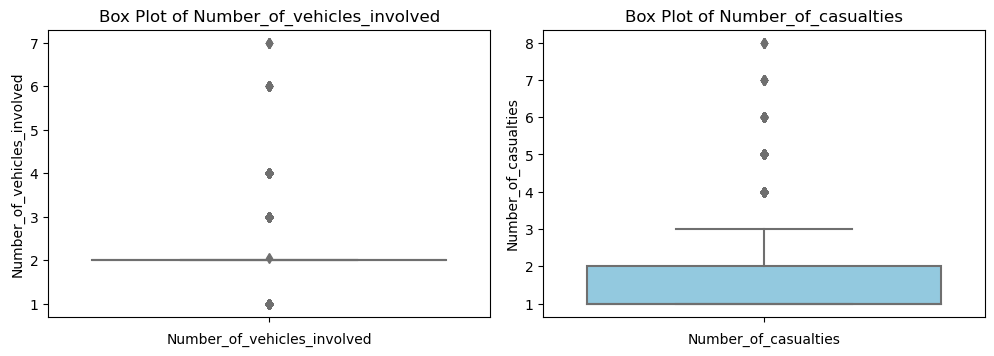

In [91]:
# Outlier Detection and Treatment:
# Use box plots and scatter plots to detect outliers.
# Decide whether to remove or transform outliers based on their impact.

# Identify numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Create box plots for each numerical feature
plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


In [92]:
# Using Z-Score Method

from scipy.stats import zscore

# Calculate Z-scores for numerical features
df_zscore = df[numerical_features].apply(zscore)

# Identify outliers (Z-score > 3 or < -3)
outliers = (df_zscore > 3) | (df_zscore < -3)

# Summarize the number of outliers in each feature
outlier_summary = outliers.sum()
print(outlier_summary)

Number_of_vehicles_involved     49
Number_of_casualties           326
dtype: int64


In [93]:
# Filtering Out Outliers

# Remove outliers from the DataFrame
df_cleaned = df[(df_zscore < 3).all(axis=1) & (df_zscore > -3).all(axis=1)]

# Check the shape of the cleaned DataFrame
print(f'Original DataFrame shape: {df.shape}')
print(f'Cleaned DataFrame shape: {df_cleaned.shape}')


Original DataFrame shape: (12317, 32)
Cleaned DataFrame shape: (11942, 32)


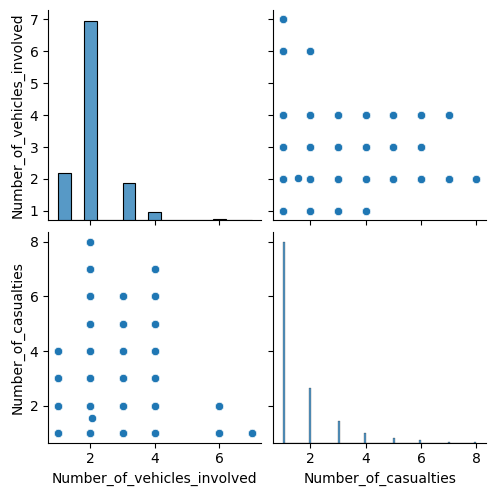

In [94]:
# Pairplot: Use pairplots to visualize relationships between pairs of numerical features.

import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
def plot_pairplot(df_cleaned, numerical_features):
    sns.pairplot(df_cleaned[numerical_features])
    plt.show()

# Example usage
numerical_features = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
plot_pairplot(df, numerical_features)

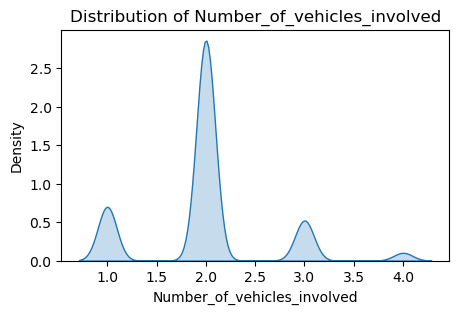

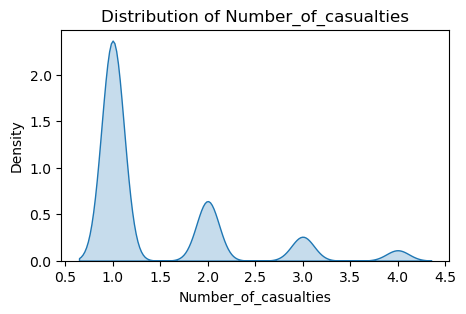

In [95]:
# Distribution Plots: 
# Use KDE (Kernel Density Estimate) plots to better understand the distribution of numerical features.
for feature in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(df_cleaned[feature], shade=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.show()

In [96]:
df_cleaned.head()

Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3  01:06:00      Sunday              18-30          Male  Junior high school   
4  01:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr           Automobile   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                 Unknown  ...   Going straight   
3     Governmental                 Unknown  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0  Driver or rider            Male                   na                 3   
1  Driver or rider            Male                   na                 3   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4  Driver or rider            Male                   na                 3   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0            Driver               Normal    Not a Pedestrian   
1            Driver               Normal    Not a Pedestrian   
2            Driver               Normal    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4            Driver               Normal    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

In [97]:
print(df_cleaned.columns)

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')


In [98]:
# Encode categorical variables
#data_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Select categorical columns
categorical_cols = df_cleaned.select_dtypes(include='object').columns

# Initialize LabelEncoder
label_encoders = {}

# Apply LabelEncoder to each categorical column
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col].astype(str))
    label_encoders[col] = le

# Check the transformed DataFrame
df_cleaned.head()

Time  Day_of_week  Age_band_of_driver  Sex_of_driver  Educational_level  \
0   733            2                   1              1                  0   
1   733            2                   2              1                  4   
2   733            2                   1              1                  4   
3    42            4                   1              1                  4   
4    42            4                   1              1                  4   

   Vehicle_driver_relation  Driving_experience  Type_of_vehicle  \
0                        0                   0                0   
1                        0                   3               11   
2                        0                   0                5   
3                        0                   2               11   
4                        0                   1                0   

   Owner_of_vehicle  Service_year_of_vehicle  ...  Vehicle_movement  \
0                 3                        3  ...                 2   
1                 3                        2  ...                 2   
2                 3                        5  ...                 2   
3                 0                        5  ...                 2   
4                 3                        2  ...                 2   

   Casualty_class  Sex_of_casualty  Age_band_of_casualty  Casualty_severity  \
0               0                1                     5                  2   
1               0                1                     5                  2   
2               0                1                     1                  2   
3               2                0                     0                  2   
4               0                1                     5                  2   

   Work_of_casuality  Fitness_of_casuality  Pedestrian_movement  \
0                  0                     2                    5   
1                  0                     2                    5   
2                  0                     2                    5   
3                  0                     2                    5   
4                  0                     2                    5   

   Cause_of_accident  Accident_severity  
0                  9                  2  
1                 16                  2  
2                  0                  1  
3                  1                  2  
4                 16                  2  

[5 rows x 32 columns]

In [99]:
# Feature Correlation with Target Variable: Calculate the correlation of features with the target 
# variable to understand which features are more influential.

correlation_with_target = df_cleaned.corr()['Accident_severity'].sort_values(ascending=False)
print(correlation_with_target)

Accident_severity              1.000000
Number_of_vehicles_involved    0.126419
Light_conditions               0.032294
Age_band_of_casualty           0.027344
Type_of_collision              0.027211
Pedestrian_movement            0.015480
Age_band_of_driver             0.009911
Cause_of_accident              0.008259
Weather_conditions             0.006793
Sex_of_driver                  0.006075
Road_surface_conditions        0.004130
Service_year_of_vehicle        0.004086
Work_of_casuality              0.003380
Defect_of_vehicle              0.002848
Educational_level             -0.001443
Driving_experience            -0.001691
Road_allignment               -0.003448
Road_surface_type             -0.003595
Type_of_vehicle               -0.003722
Casualty_class                -0.004579
Sex_of_casualty               -0.005553
Day_of_week                   -0.006065
Casualty_severity             -0.009271
Owner_of_vehicle              -0.009766
Vehicle_driver_relation       -0.010800


In [100]:
# Splitting the dataset
X = df_cleaned.drop(columns=['Accident_severity'])
y = df_cleaned['Accident_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

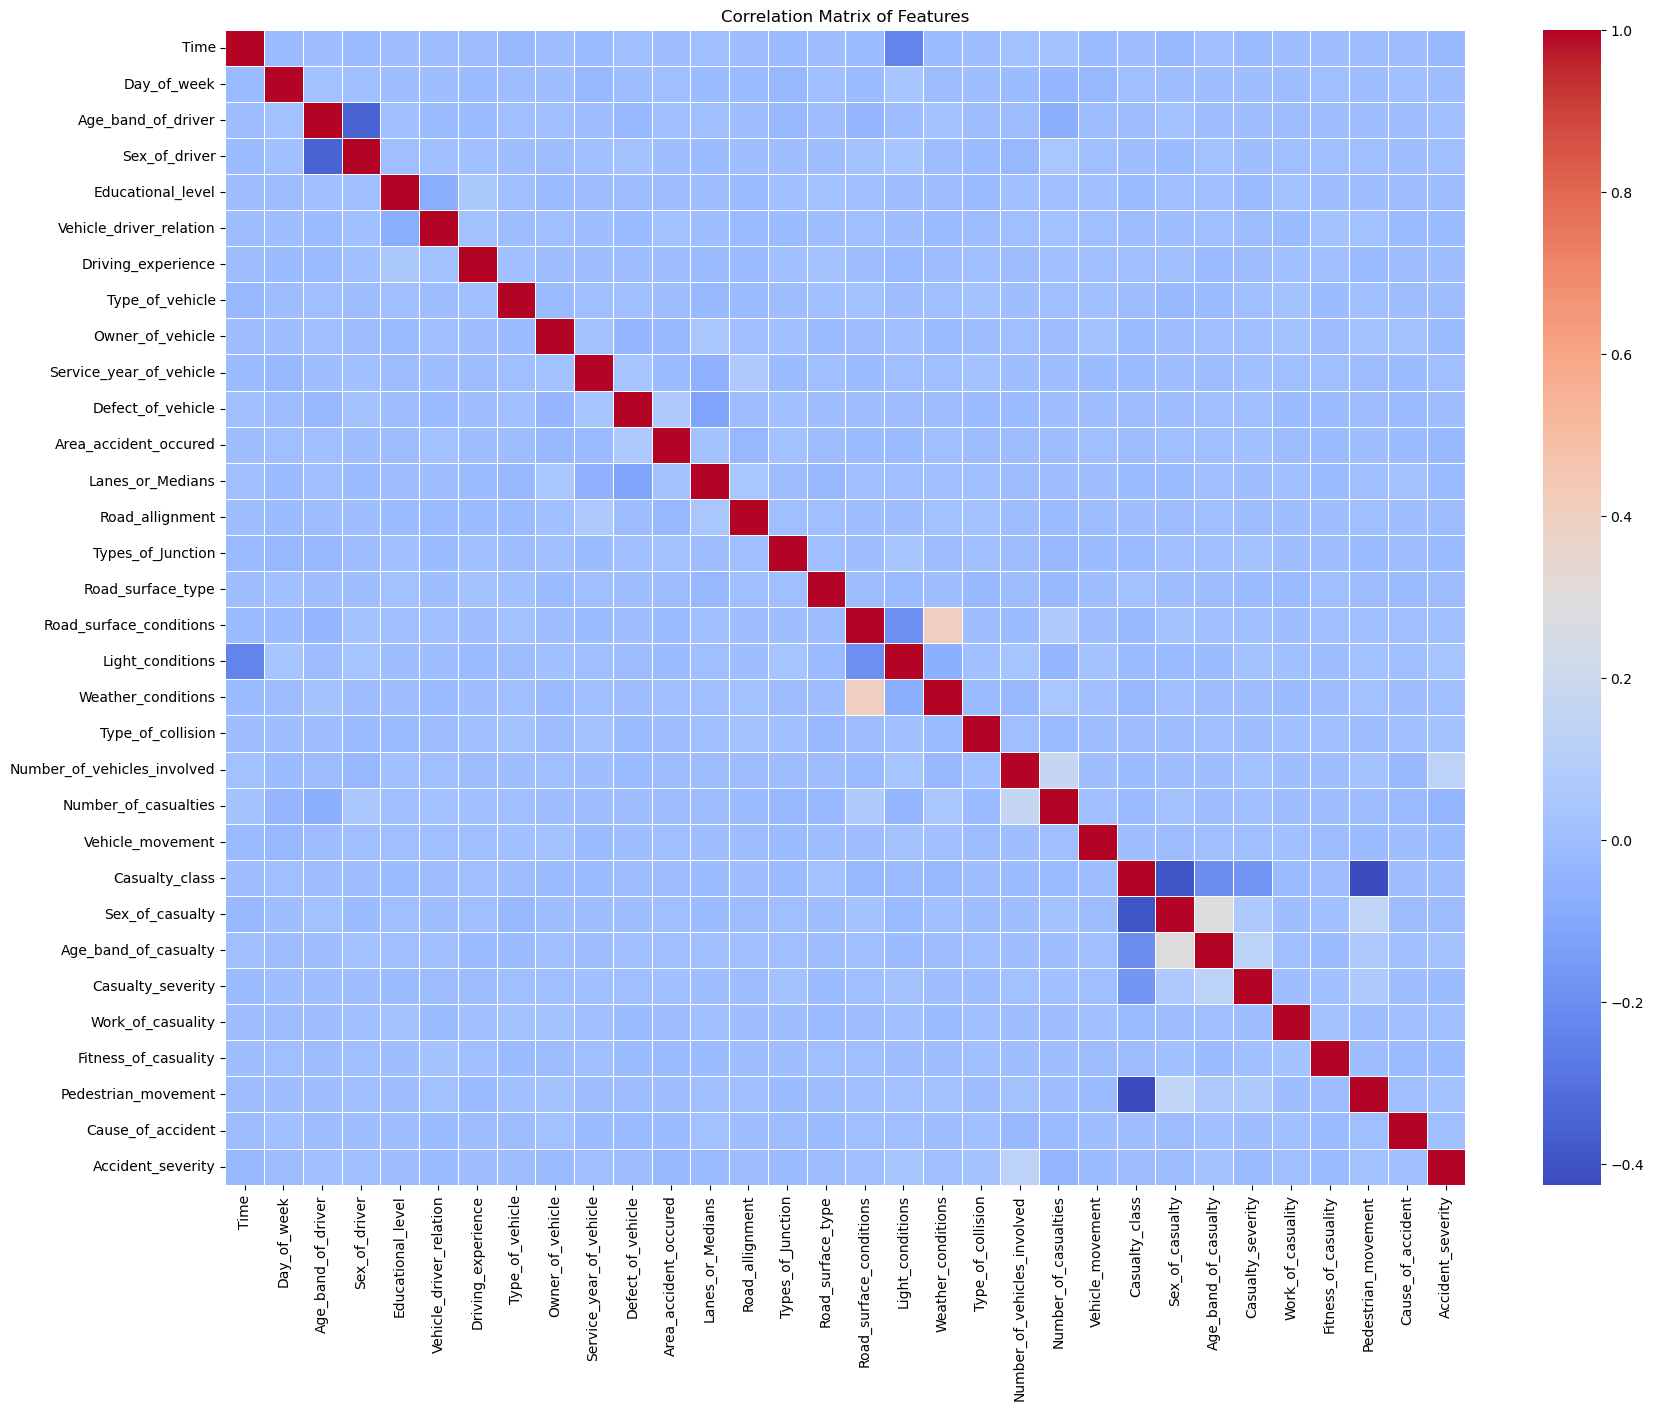

In [101]:
# Correlation matrix
corr_matrix = df_cleaned.corr()
# Heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

In [102]:
# Hyperparameter Tuning with GridSearchCV

# Decision Tree with hyperparameter tuning
dt_params = {'max_depth': [3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
best_dt = dt_grid.best_estimator_

# Random Forest with hyperparameter tuning
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Gradient Boosting with hyperparameter tuning
gb_params = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 7]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=5, scoring='accuracy')
gb_grid.fit(X_train, y_train)
best_gb = gb_grid.best_estimator_

# Logistic Regression with hyperparameter tuning
lr_params = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)
best_lr = lr_grid.best_estimator_

--- Best Decision Tree ---
Accuracy: 0.8626849009210159
Precision (macro): 0.47326372655965926
Recall (macro): 0.33982840676320425
F1 Score (macro): 0.322840786028486
ROC AUC (macro): 0.6194688753769894
Confusion Matrix:
[[   0    0   41]
 [   0   10  443]
 [   0    8 3081]]



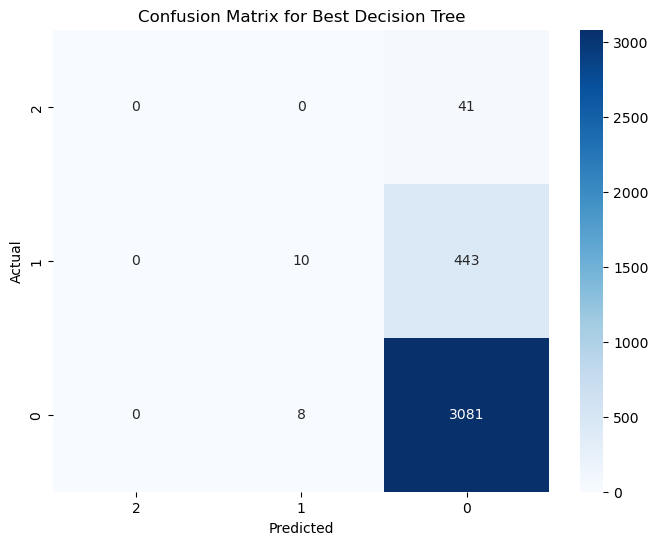

--- Best Random Forest ---
Accuracy: 0.8626849009210159
Precision (macro): 0.6208694033324025
Recall (macro): 0.33480500367917587
F1 Score (macro): 0.3116760301168097
ROC AUC (macro): 0.7038177764458737
Confusion Matrix:
[[   0    0   41]
 [   0    2  451]
 [   0    0 3089]]



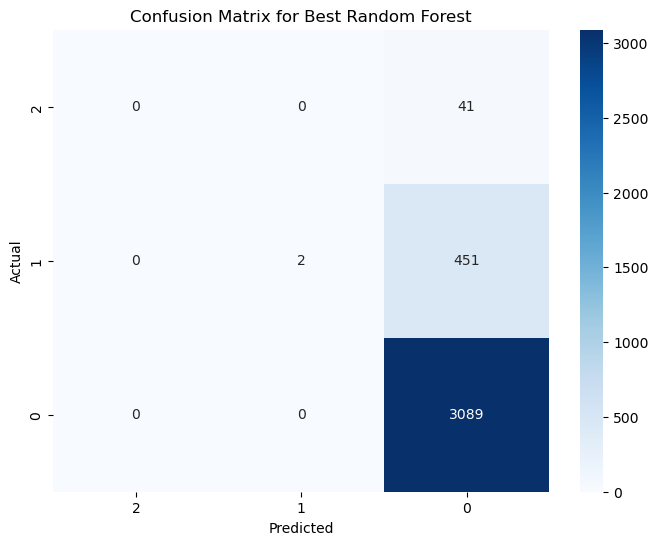

--- Best Gradient Boosting ---
Accuracy: 0.8632430923806865
Precision (macro): 0.6707127295362589
Recall (macro): 0.3920856662295835
F1 Score (macro): 0.4146260032433606
ROC AUC (macro): 0.7486104356749811
Confusion Matrix:
[[   5    0   36]
 [   0   29  424]
 [   3   27 3059]]



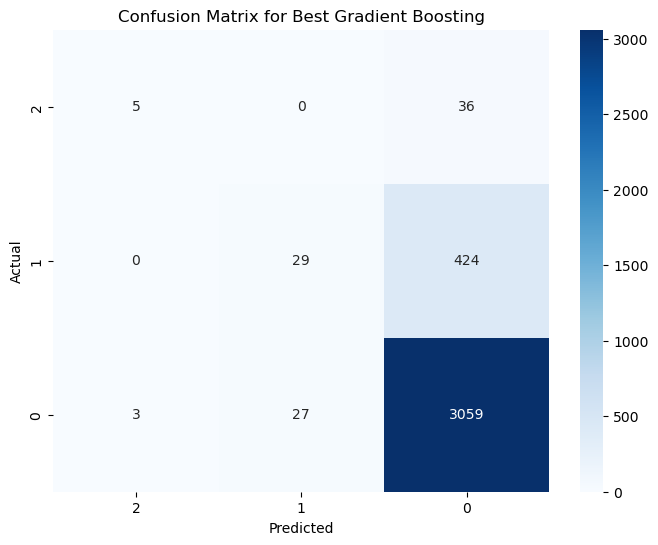

--- Best Logistic Regression ---
Accuracy: 0.8618476137315099
Precision (macro): 0.2873627396240462
Recall (macro): 0.3332254235459156
F1 Score (macro): 0.3085994103832509
ROC AUC (macro): 0.681081840276054
Confusion Matrix:
[[   0    0   41]
 [   0    0  453]
 [   1    0 3088]]



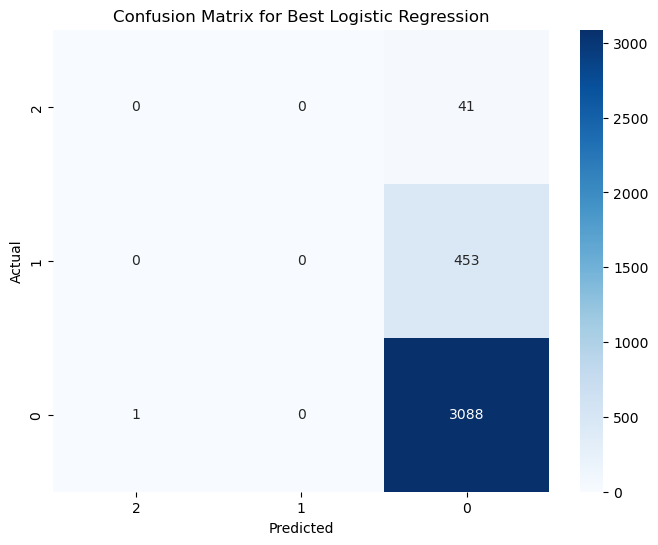

In [103]:
### 4. Model Evaluation

# Model Evaluation
def evaluate_model(y_test, y_pred, y_proba, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision (macro): {precision_score(y_test, y_pred, average='macro')}")
    print(f"Recall (macro): {recall_score(y_test, y_pred, average='macro')}")
    print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
    # Use y_proba for ROC AUC score
    print(f"ROC AUC (macro): {roc_auc_score(y_test, y_proba, average='macro', multi_class='ovr')}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Predictions and evaluation for Decision Tree
y_pred_best_dt = best_dt.predict(X_test)
y_proba_best_dt = best_dt.predict_proba(X_test)
evaluate_model(y_test, y_pred_best_dt, y_proba_best_dt, "Best Decision Tree")

# Predictions and evaluation for Random Forest
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)
evaluate_model(y_test, y_pred_best_rf, y_proba_best_rf, "Best Random Forest")

# Predictions and evaluation for Gradient Boosting
y_pred_best_gb = best_gb.predict(X_test)
y_proba_best_gb = best_gb.predict_proba(X_test)
evaluate_model(y_test, y_pred_best_gb, y_proba_best_gb, "Best Gradient Boosting")

# Predictions and evaluation for Logistic Regression
y_pred_best_lr = best_lr.predict(X_test)
y_proba_best_lr = best_lr.predict_proba(X_test)
evaluate_model(y_test, y_pred_best_lr, y_proba_best_lr, "Best Logistic Regression")

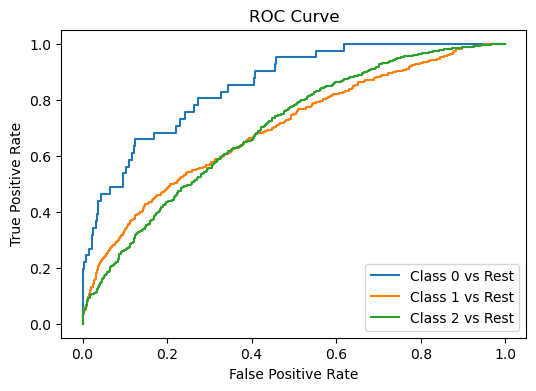

In [104]:
# ROC Curve
from sklearn.metrics import roc_curve

# Plot ROC Curve
def plot_roc_curve(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    thresh = {}
    n_class = y_proba.shape[1]
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test == i, y_proba[:, i])
    plt.figure(figsize=(6, 4))
    for i in range(n_class):
        plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} vs Rest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

# Example usage
plot_roc_curve(best_gb, X_test, y_test)


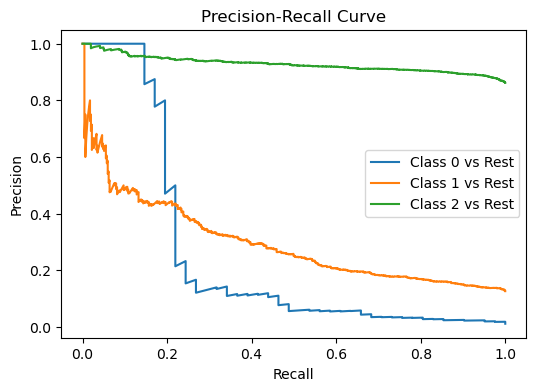

In [105]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve
def plot_pr_curve(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)
    precision = {}
    recall = {}
    thresh = {}
    n_class = y_proba.shape[1]
    for i in range(n_class):    
        precision[i], recall[i], thresh[i] = precision_recall_curve(y_test == i, y_proba[:, i])
    plt.figure(figsize=(6, 4))
    for i in range(n_class):
        plt.plot(recall[i], precision[i], linestyle='-', label=f'Class {i} vs Rest')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

# Example usage
plot_pr_curve(best_gb, X_test, y_test)


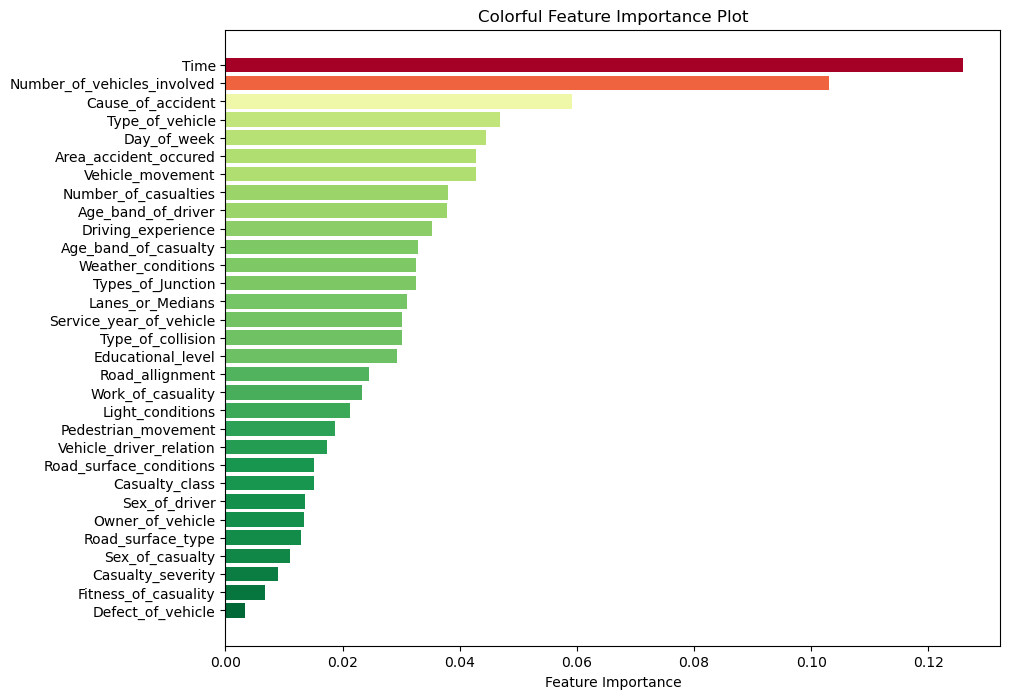

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_colorful_feature_importance(model, X_train):
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)
    
    # Normalize the feature importances for color mapping
    norm = Normalize(vmin=min(feature_importances), vmax=max(feature_importances))
    cmap = cm.get_cmap('RdYlGn_r')  # Reverse the colormap (red for high, green for low)

    plt.figure(figsize=(10, 8))
    bar_colors = cmap(norm(feature_importances[sorted_idx]))
    
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], color=bar_colors, align='center')
    plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Colorful Feature Importance Plot')
    plt.show()

# Example usage
plot_colorful_feature_importance(best_rf, X_train)

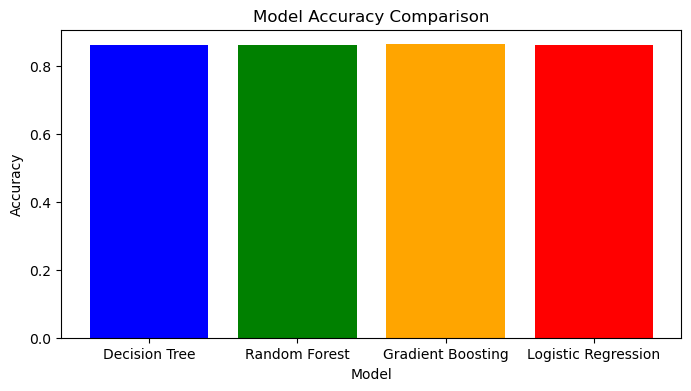

In [123]:
# Accuracy Bar Chart
model_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Logistic Regression']
accuracies = [accuracy_score(y_test, y_pred_best_dt), 
              accuracy_score(y_test, y_pred_best_rf), 
              accuracy_score(y_test, y_pred_best_gb), 
              accuracy_score(y_test, y_pred_best_lr)]

plt.figure(figsize=(8, 4))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


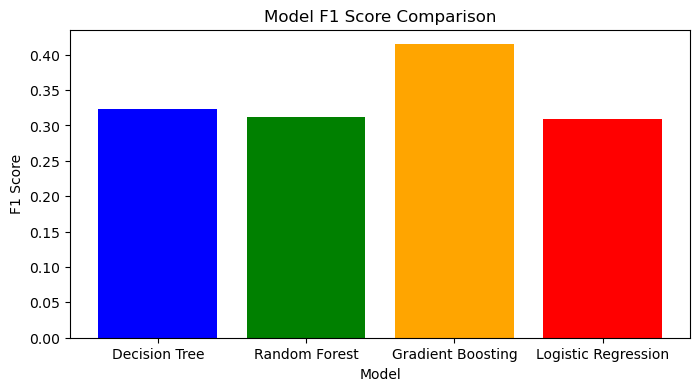

In [122]:
# F1 Score Bar Chart
f1_scores = [f1_score(y_test, y_pred_best_dt, average='macro'), 
             f1_score(y_test, y_pred_best_rf, average='macro'), 
             f1_score(y_test, y_pred_best_gb, average='macro'), 
             f1_score(y_test, y_pred_best_lr, average='macro')]

plt.figure(figsize=(8, 4))
plt.bar(model_names, f1_scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.show()


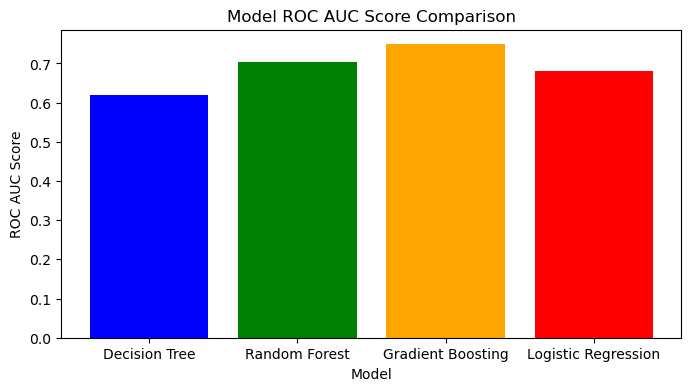

In [121]:
# ROC AUC Score Comparison
roc_auc_scores = [roc_auc_score(y_test, y_proba_best_dt, average='macro', multi_class='ovr'), 
                  roc_auc_score(y_test, y_proba_best_rf, average='macro', multi_class='ovr'), 
                  roc_auc_score(y_test, y_proba_best_gb, average='macro', multi_class='ovr'), 
                  roc_auc_score(y_test, y_proba_best_lr, average='macro', multi_class='ovr')]

plt.figure(figsize=(8, 4))
plt.bar(model_names, roc_auc_scores, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Model')
plt.ylabel('ROC AUC Score')
plt.title('Model ROC AUC Score Comparison')
plt.show()


In [110]:
# List of features in X_test
#print(X_test.columns.tolist())

In [111]:
##print(f"Length of shap_values: {len(shap_values)}")
#for i, sv in enumerate(shap_values):
#    print(f"Shape of shap_values[{i}]: {sv.shape}")

In [112]:
#shap_values_fixed = shap_values[0].T if shap_values[0].shape[0] == X_test.shape[1] else shap_values[0]
#print(f"Fixed SHAP values shape: {shap_values_fixed.shape}")

<Figure size 200x100 with 0 Axes>

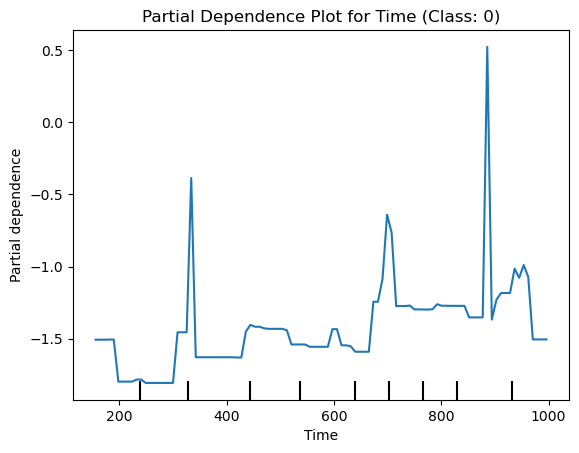

<Figure size 200x100 with 0 Axes>

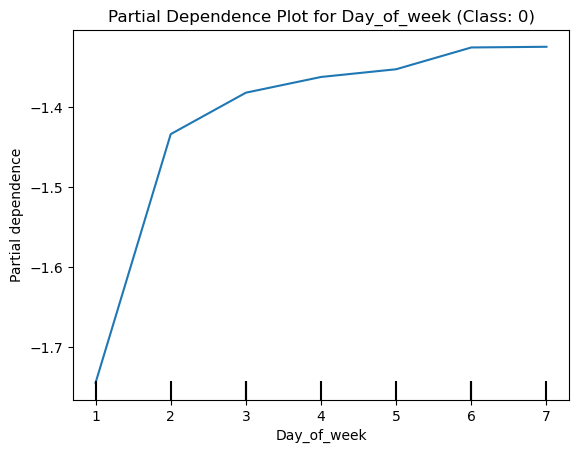

<Figure size 200x100 with 0 Axes>

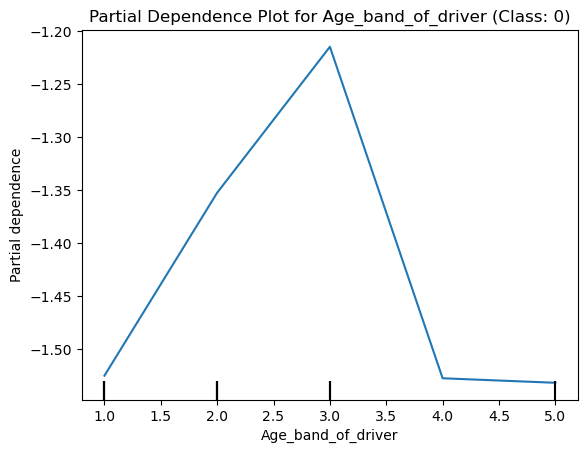

<Figure size 200x100 with 0 Axes>

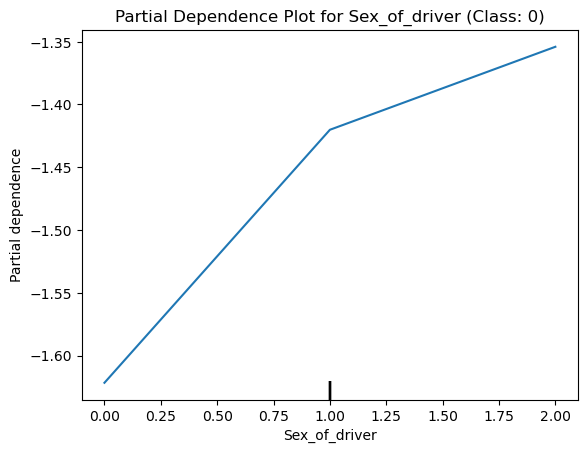

<Figure size 200x100 with 0 Axes>

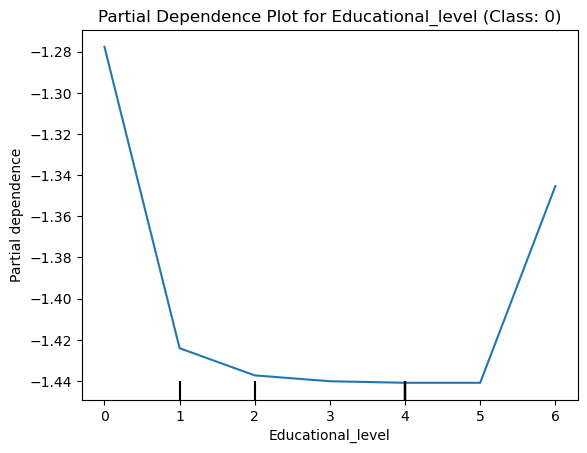

<Figure size 200x100 with 0 Axes>

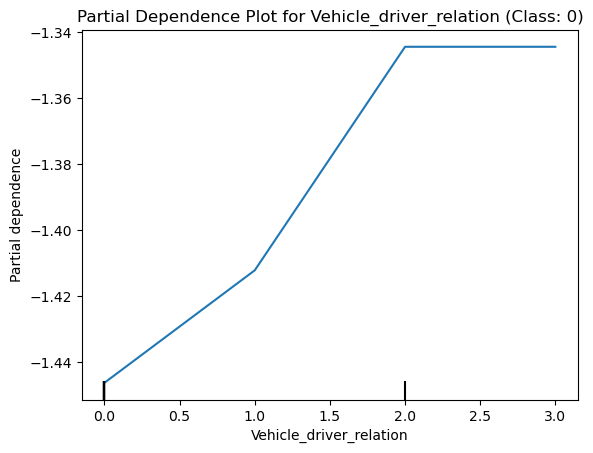

<Figure size 200x100 with 0 Axes>

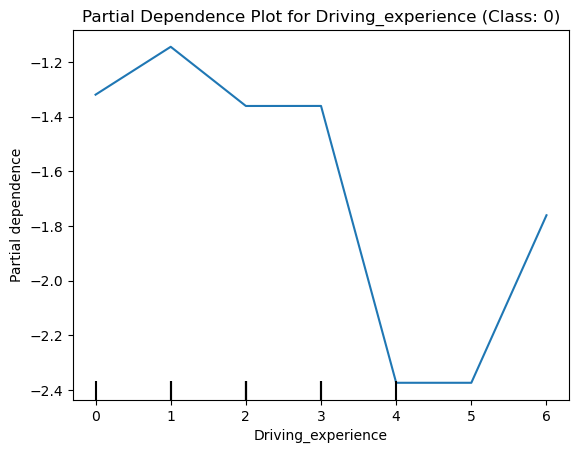

<Figure size 200x100 with 0 Axes>

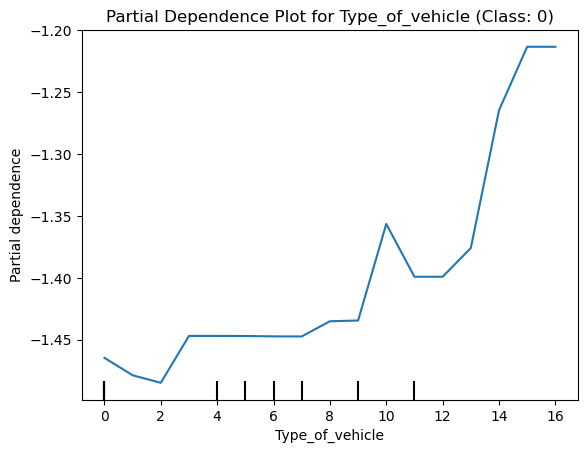

<Figure size 200x100 with 0 Axes>

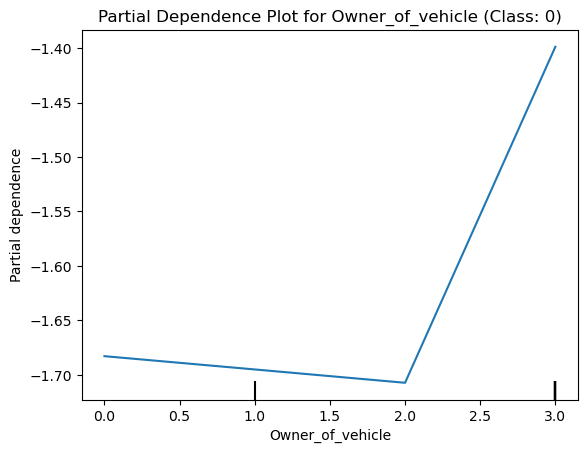

<Figure size 200x100 with 0 Axes>

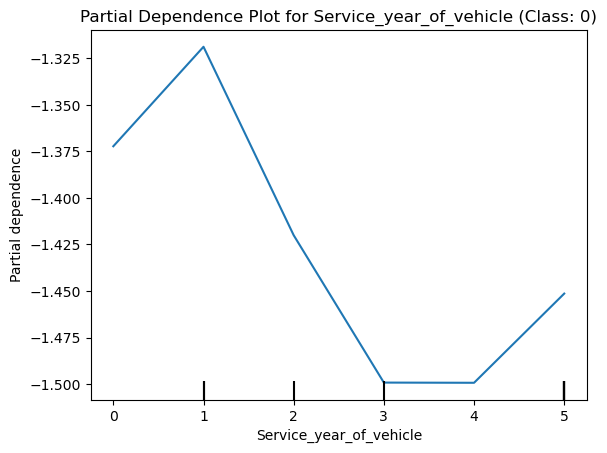

<Figure size 200x100 with 0 Axes>

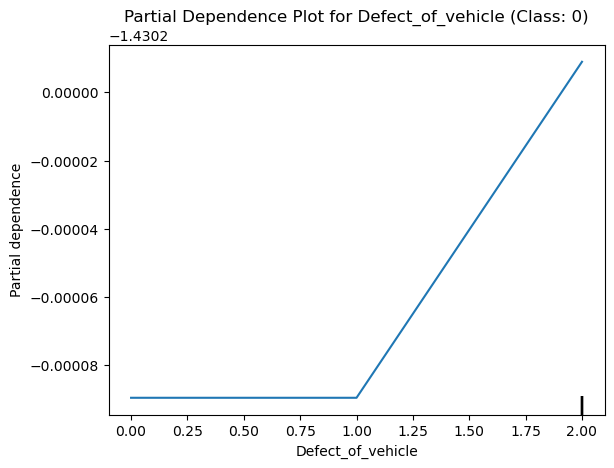

<Figure size 200x100 with 0 Axes>

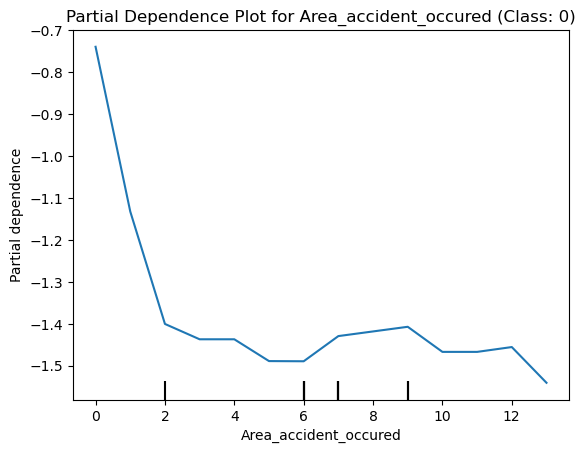

<Figure size 200x100 with 0 Axes>

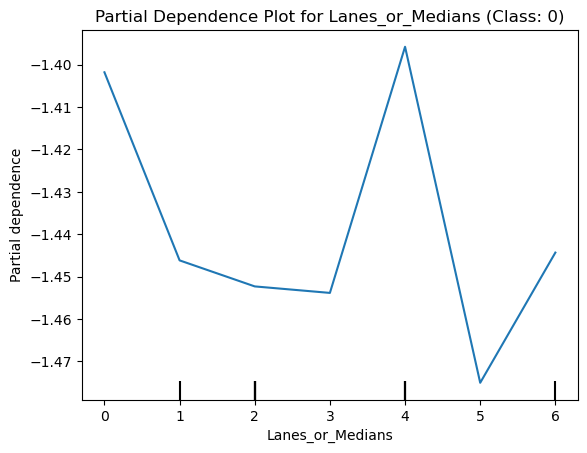

<Figure size 200x100 with 0 Axes>

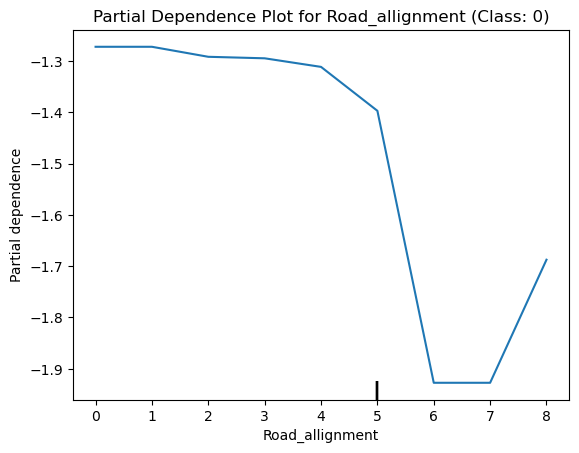

<Figure size 200x100 with 0 Axes>

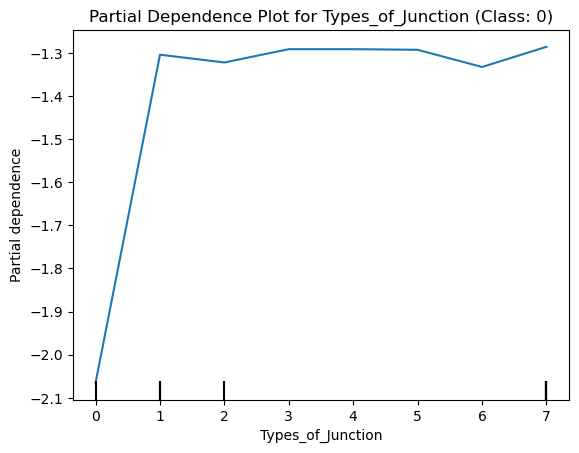

<Figure size 200x100 with 0 Axes>

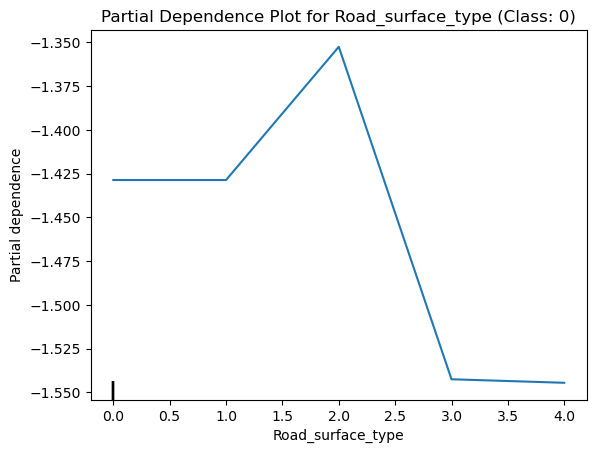

<Figure size 200x100 with 0 Axes>

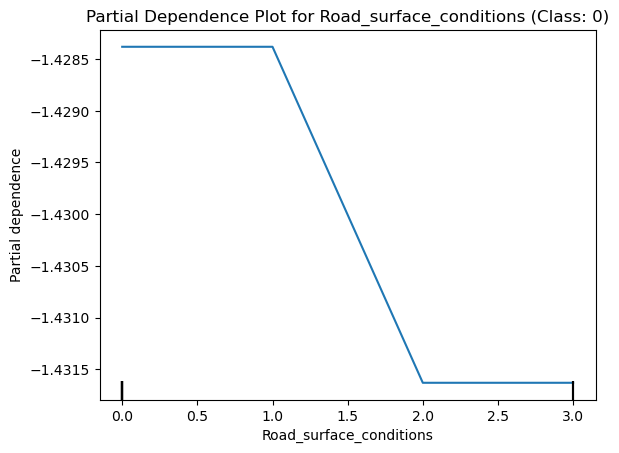

<Figure size 200x100 with 0 Axes>

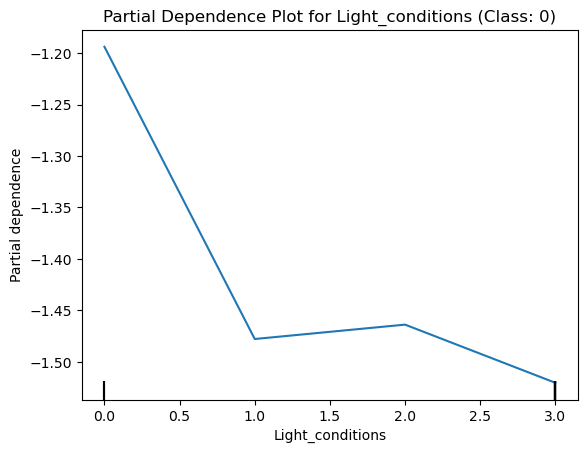

<Figure size 200x100 with 0 Axes>

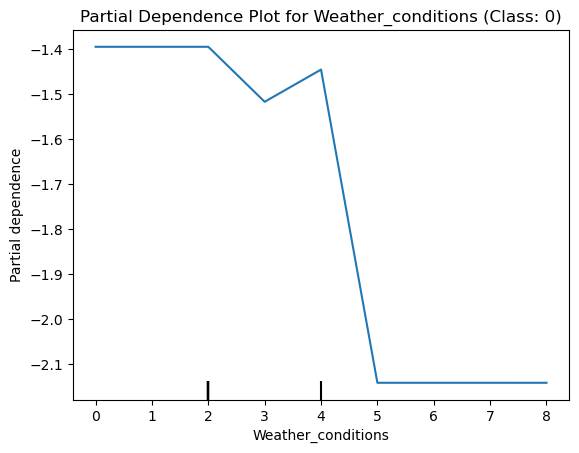

<Figure size 200x100 with 0 Axes>

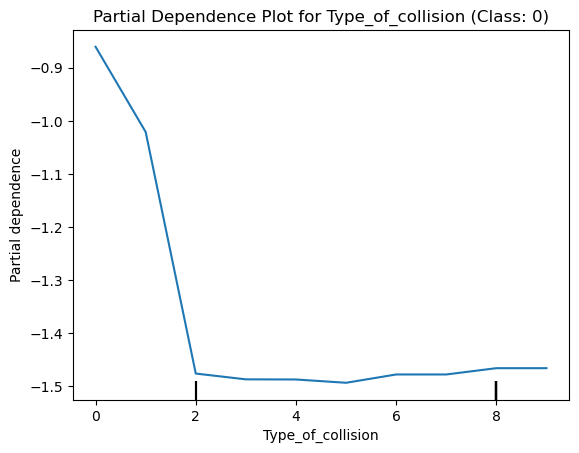

<Figure size 200x100 with 0 Axes>

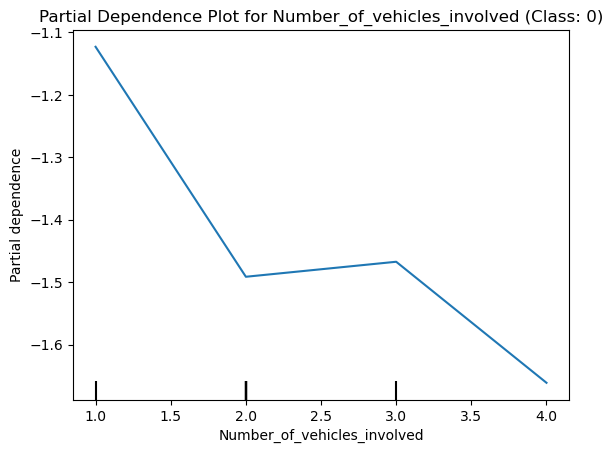

<Figure size 200x100 with 0 Axes>

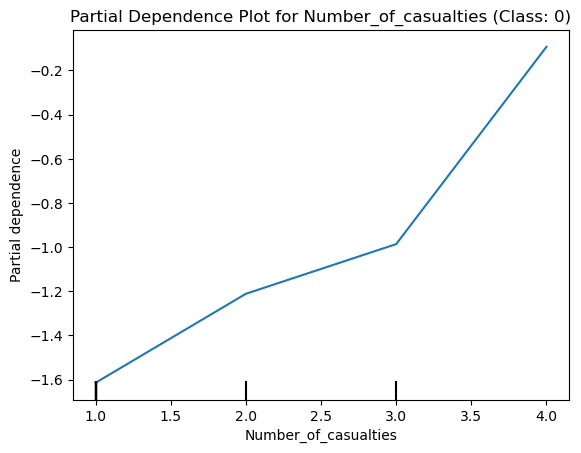

<Figure size 200x100 with 0 Axes>

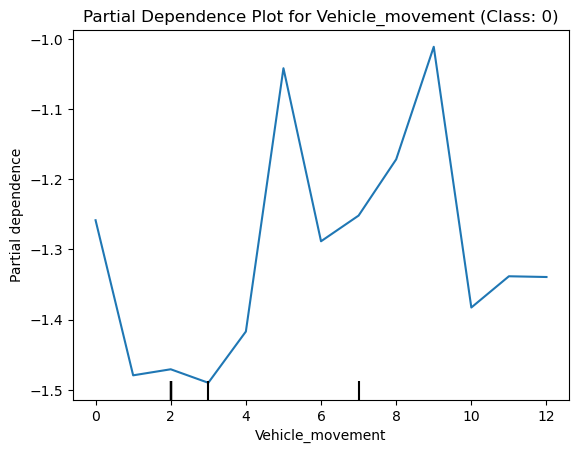

<Figure size 200x100 with 0 Axes>

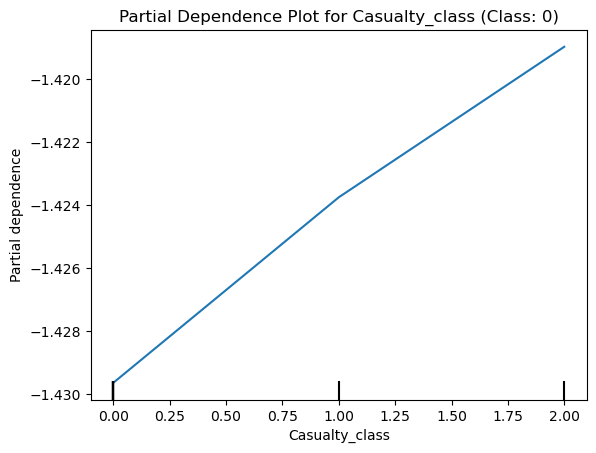

<Figure size 200x100 with 0 Axes>

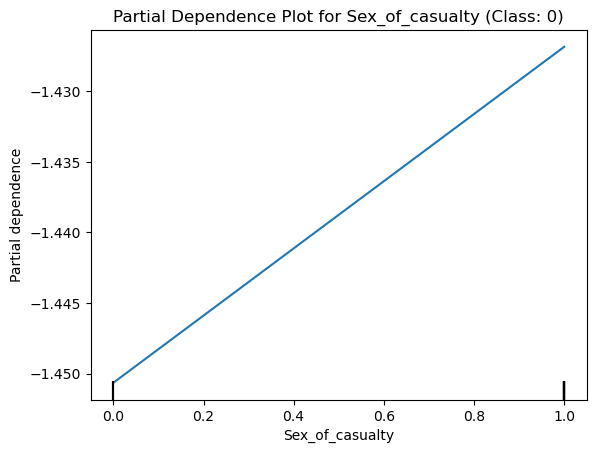

<Figure size 200x100 with 0 Axes>

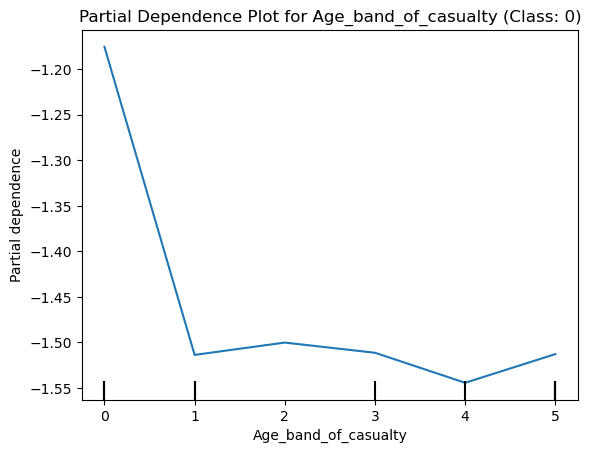

<Figure size 200x100 with 0 Axes>

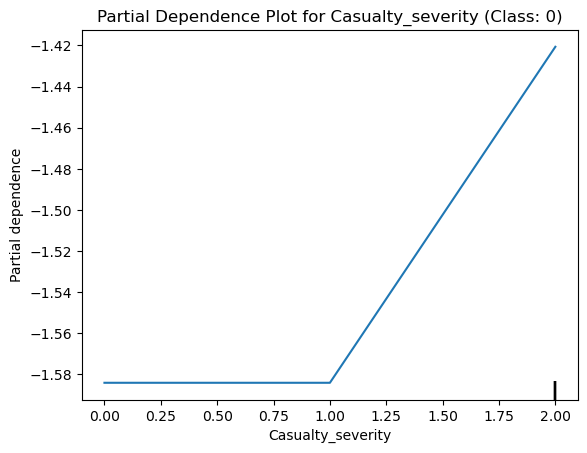

<Figure size 200x100 with 0 Axes>

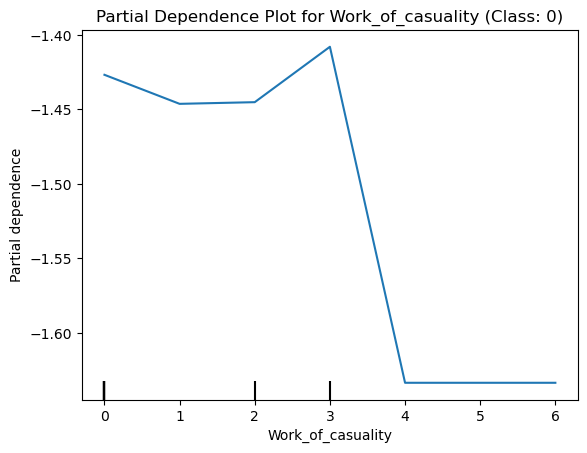

<Figure size 200x100 with 0 Axes>

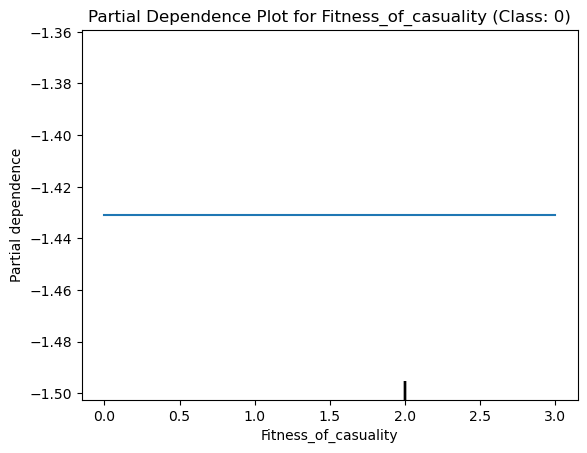

<Figure size 200x100 with 0 Axes>

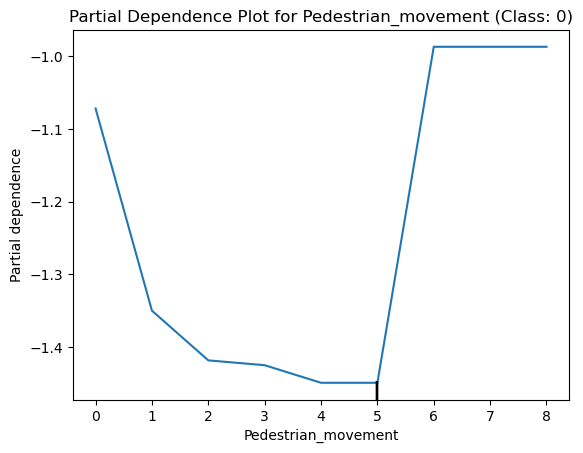

<Figure size 200x100 with 0 Axes>

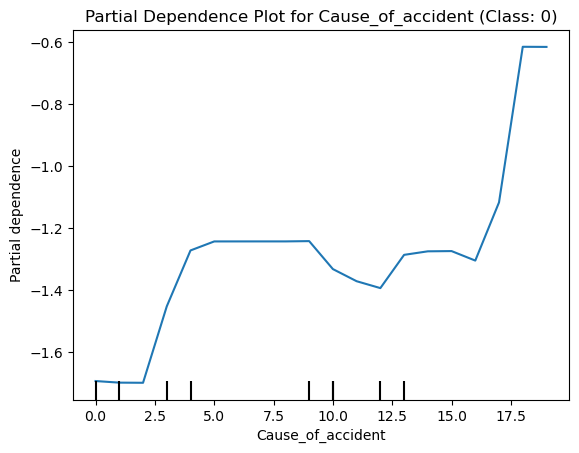

<Figure size 200x100 with 0 Axes>

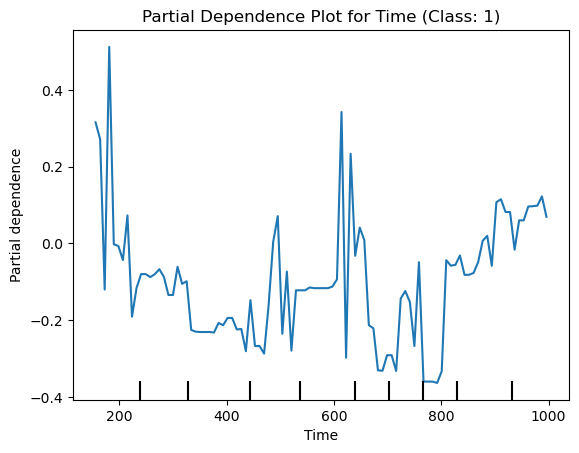

<Figure size 200x100 with 0 Axes>

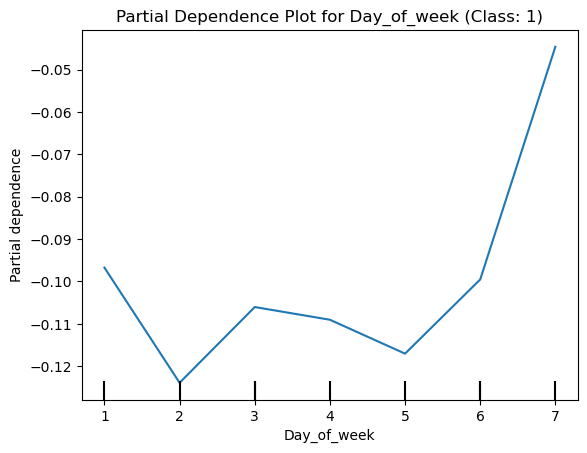

<Figure size 200x100 with 0 Axes>

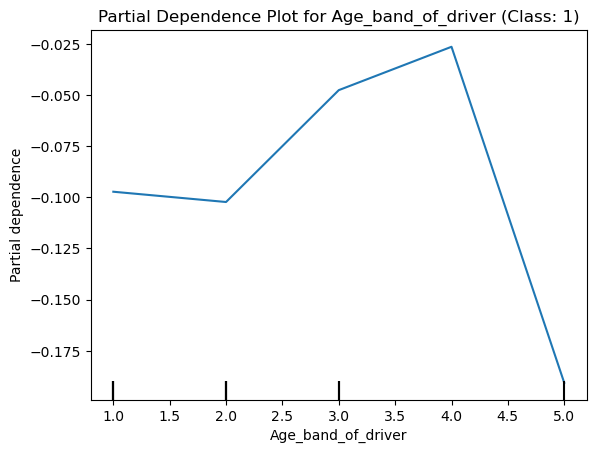

<Figure size 200x100 with 0 Axes>

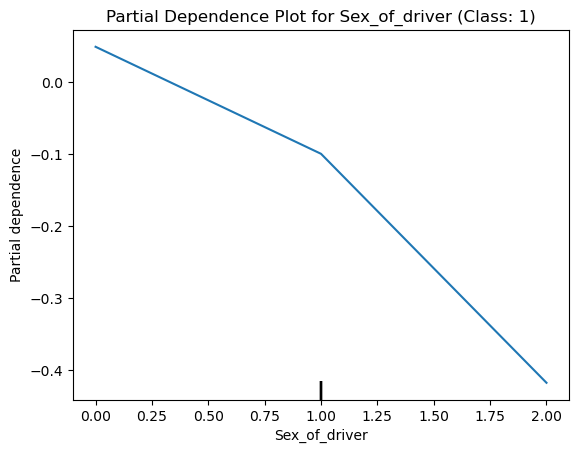

<Figure size 200x100 with 0 Axes>

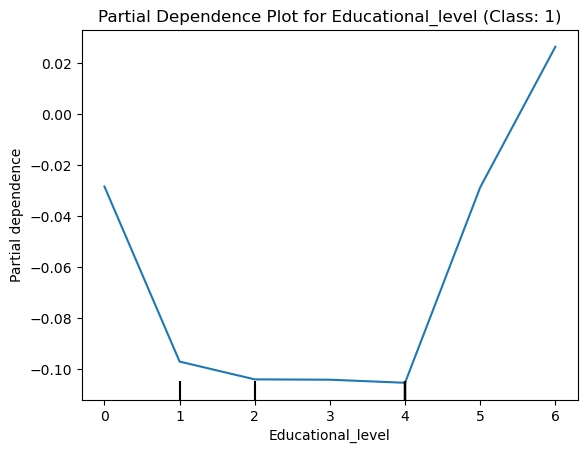

<Figure size 200x100 with 0 Axes>

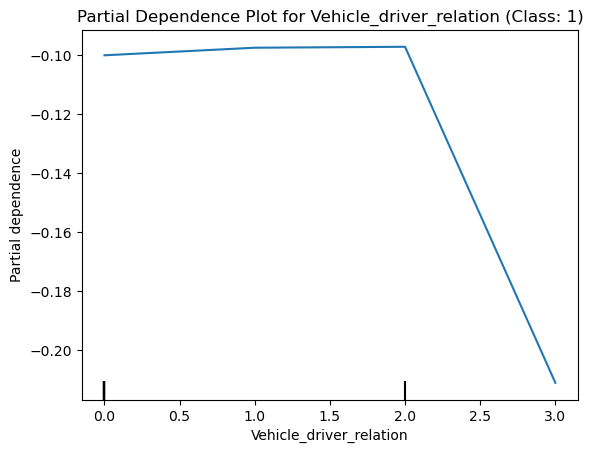

<Figure size 200x100 with 0 Axes>

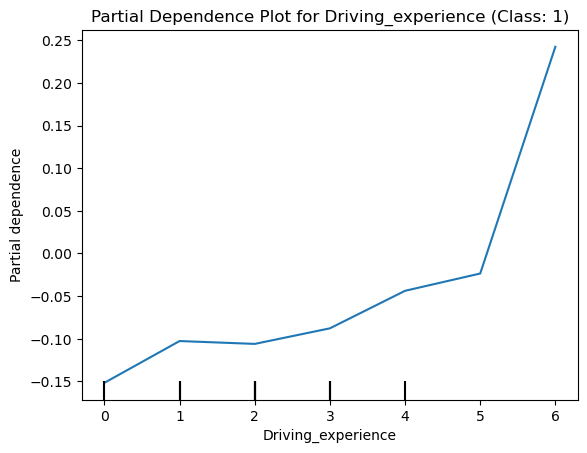

<Figure size 200x100 with 0 Axes>

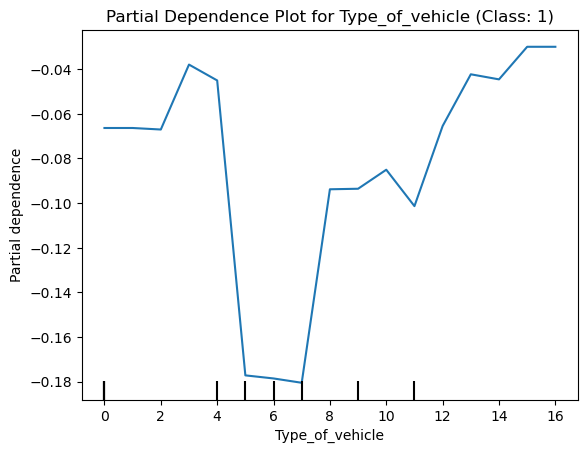

<Figure size 200x100 with 0 Axes>

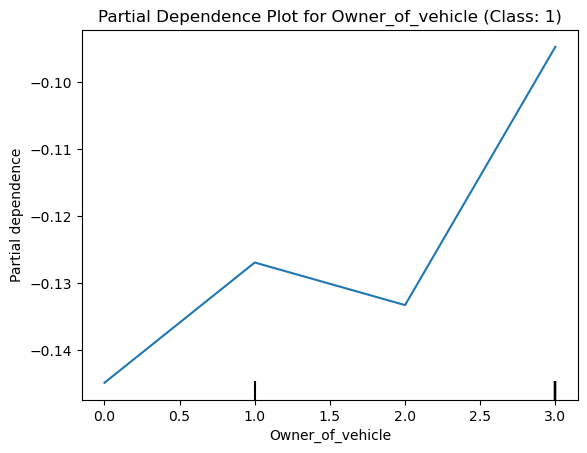

<Figure size 200x100 with 0 Axes>

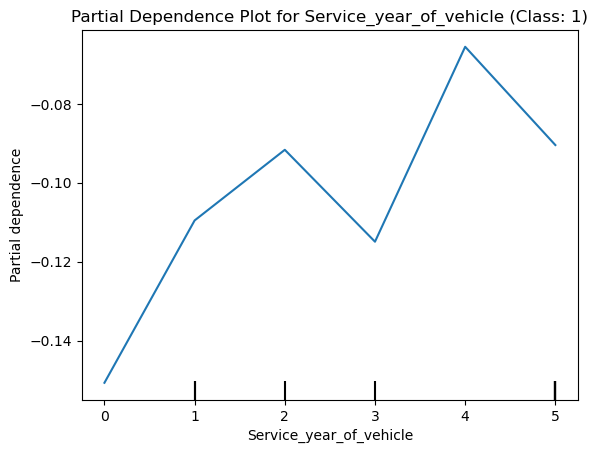

<Figure size 200x100 with 0 Axes>

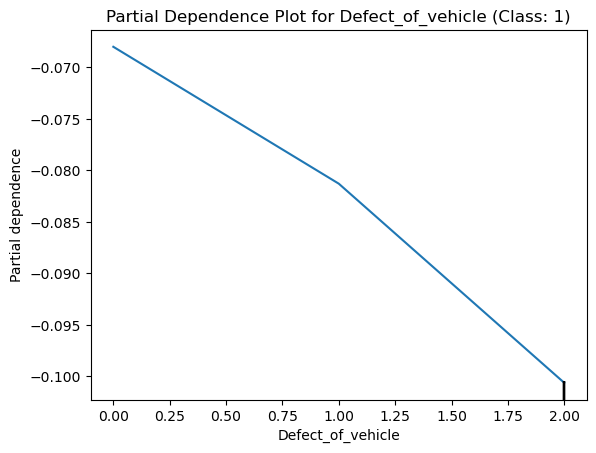

<Figure size 200x100 with 0 Axes>

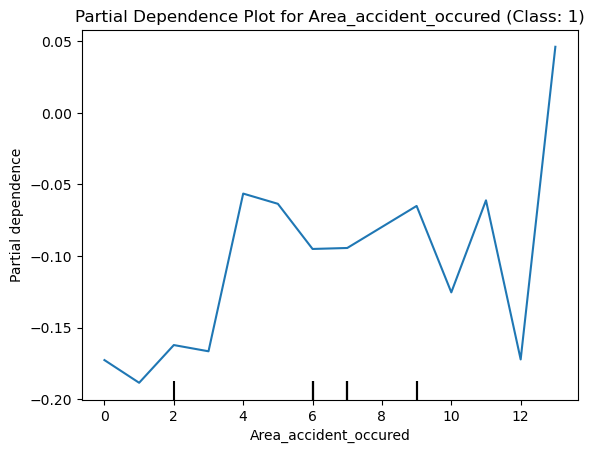

<Figure size 200x100 with 0 Axes>

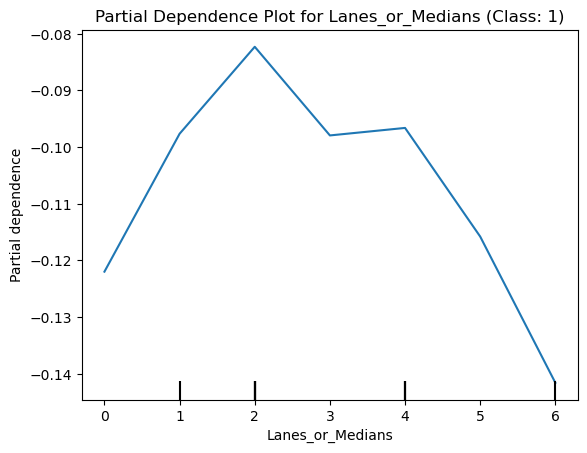

<Figure size 200x100 with 0 Axes>

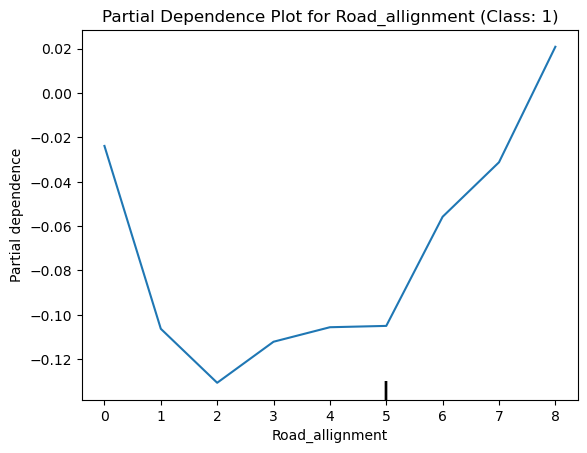

<Figure size 200x100 with 0 Axes>

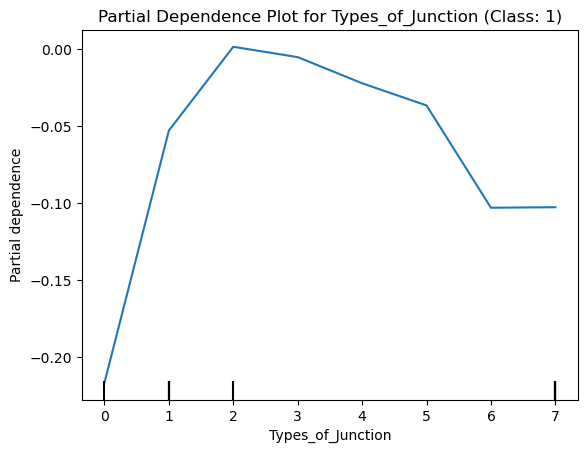

<Figure size 200x100 with 0 Axes>

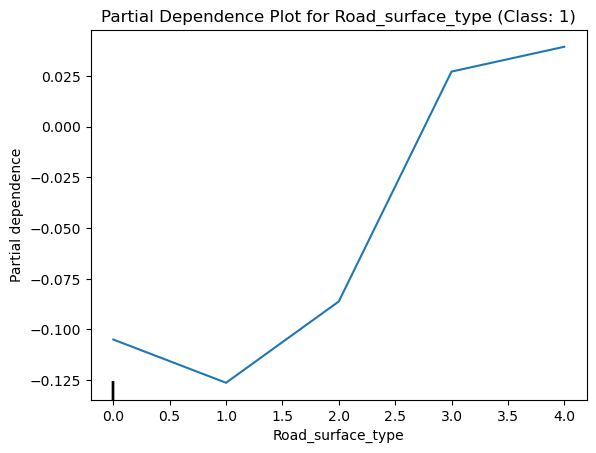

<Figure size 200x100 with 0 Axes>

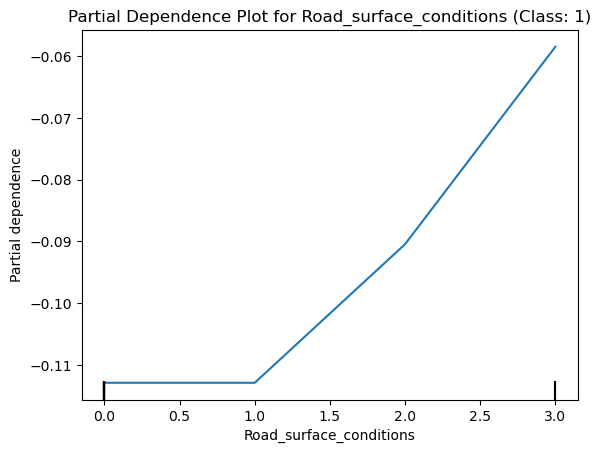

<Figure size 200x100 with 0 Axes>

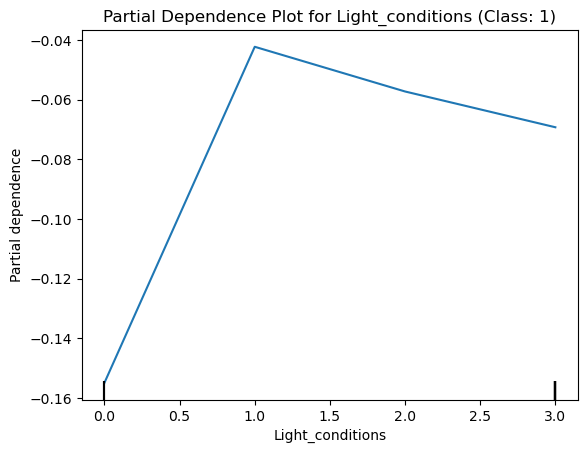

<Figure size 200x100 with 0 Axes>

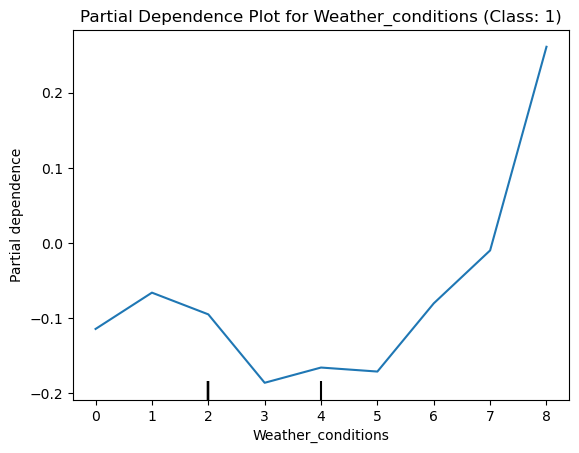

<Figure size 200x100 with 0 Axes>

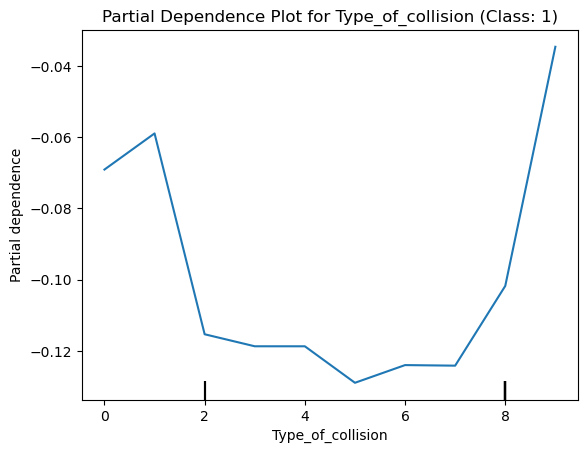

<Figure size 200x100 with 0 Axes>

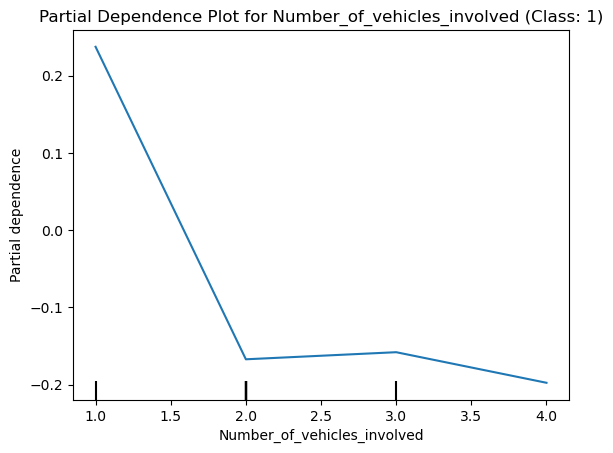

<Figure size 200x100 with 0 Axes>

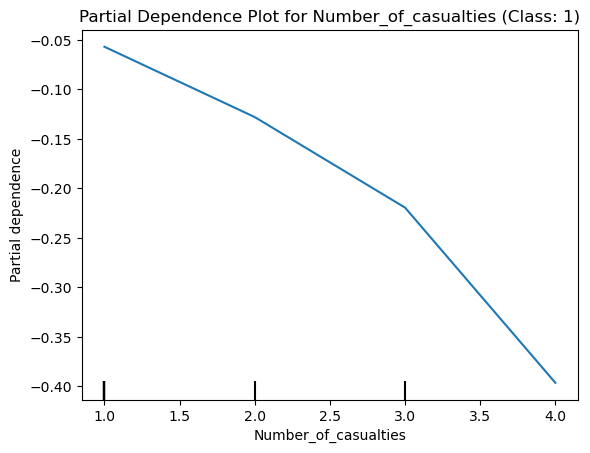

<Figure size 200x100 with 0 Axes>

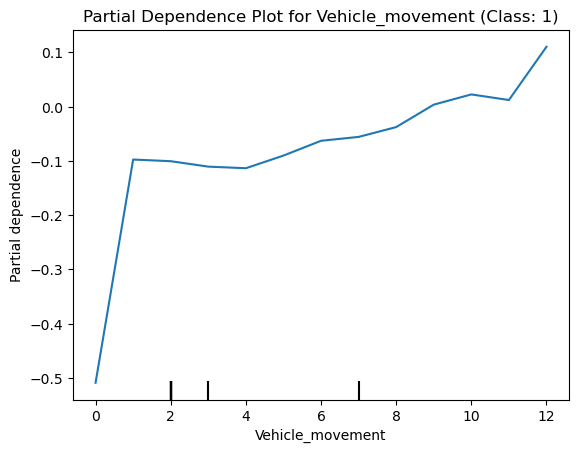

<Figure size 200x100 with 0 Axes>

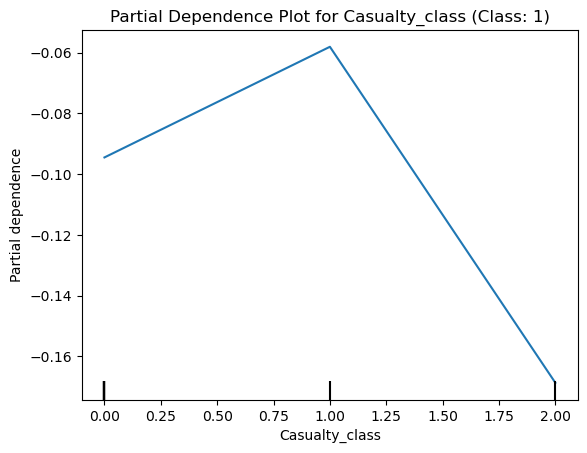

<Figure size 200x100 with 0 Axes>

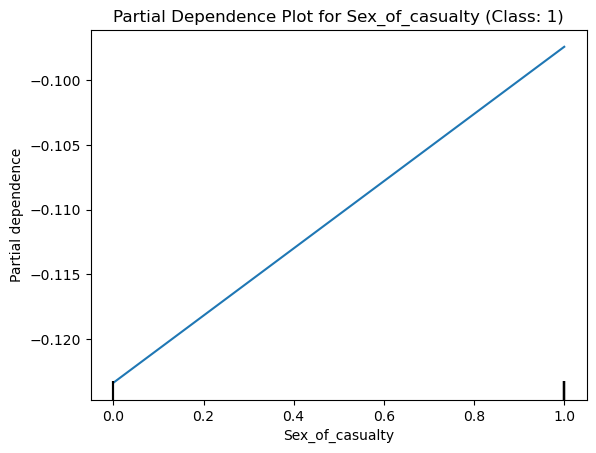

<Figure size 200x100 with 0 Axes>

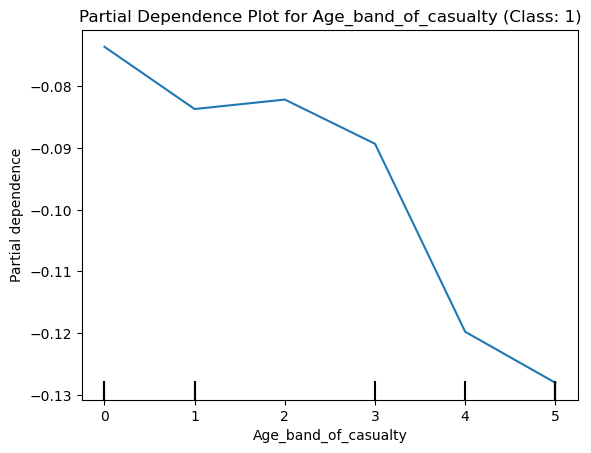

<Figure size 200x100 with 0 Axes>

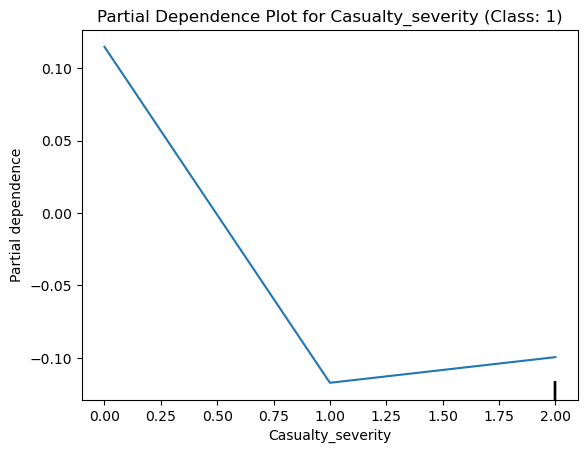

<Figure size 200x100 with 0 Axes>

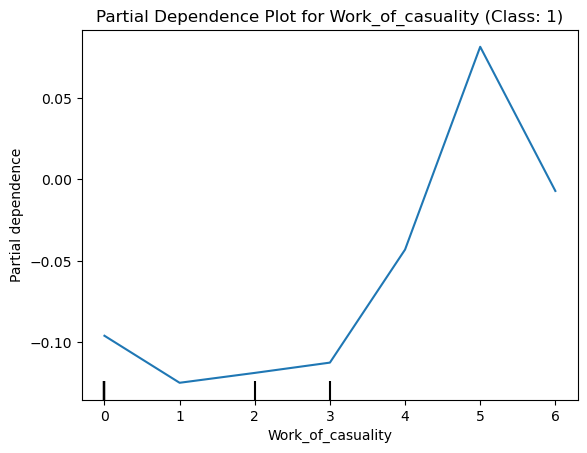

<Figure size 200x100 with 0 Axes>

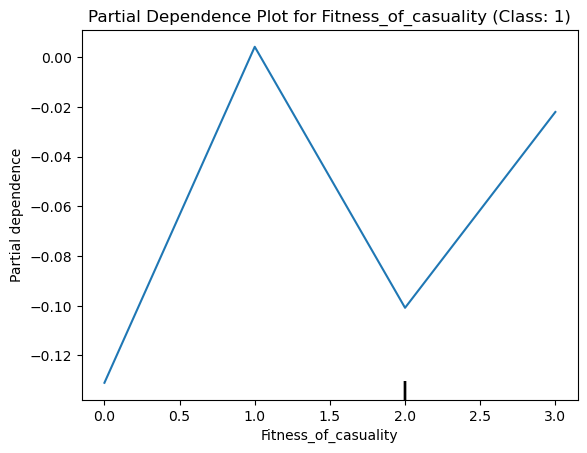

<Figure size 200x100 with 0 Axes>

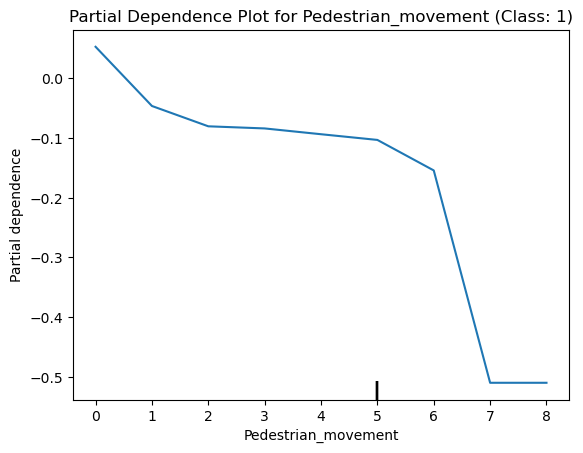

<Figure size 200x100 with 0 Axes>

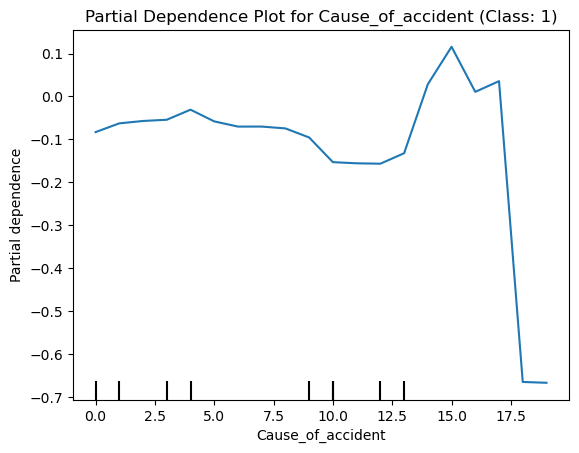

<Figure size 200x100 with 0 Axes>

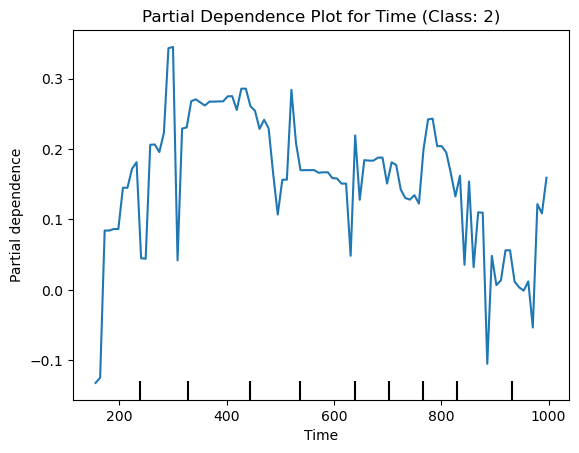

<Figure size 200x100 with 0 Axes>

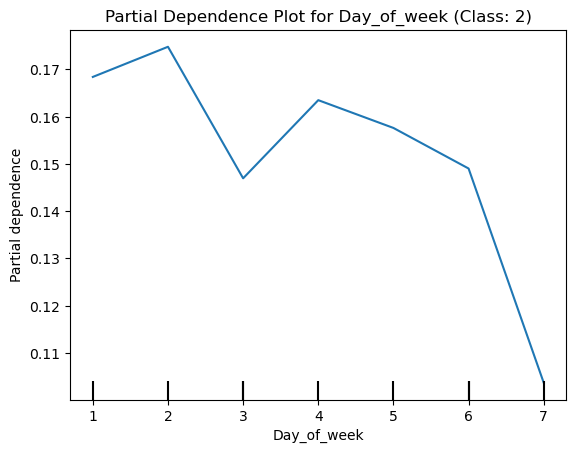

<Figure size 200x100 with 0 Axes>

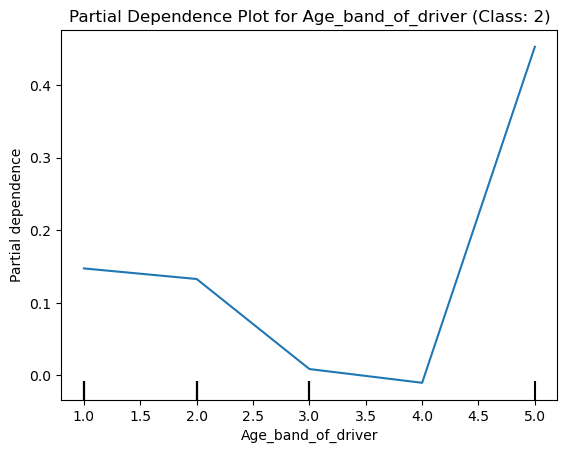

<Figure size 200x100 with 0 Axes>

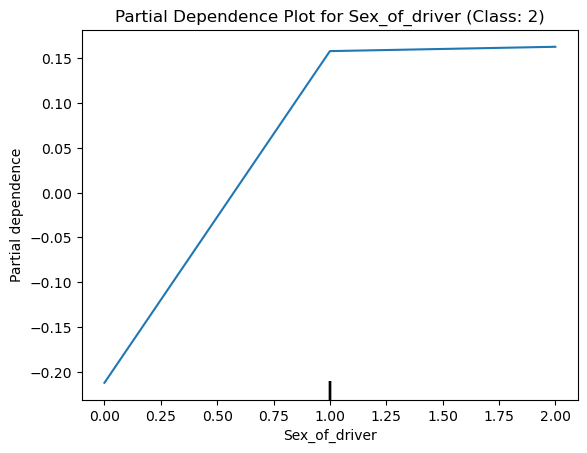

<Figure size 200x100 with 0 Axes>

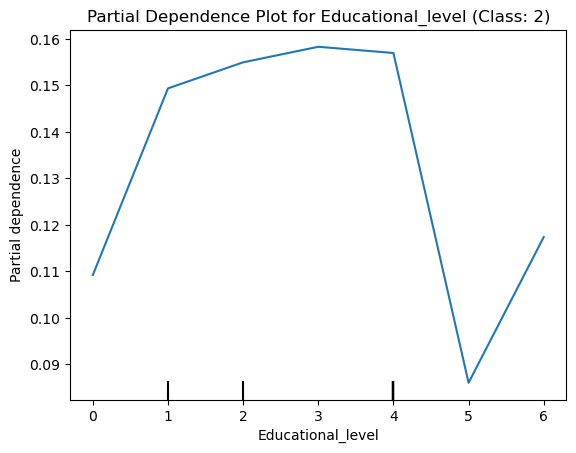

<Figure size 200x100 with 0 Axes>

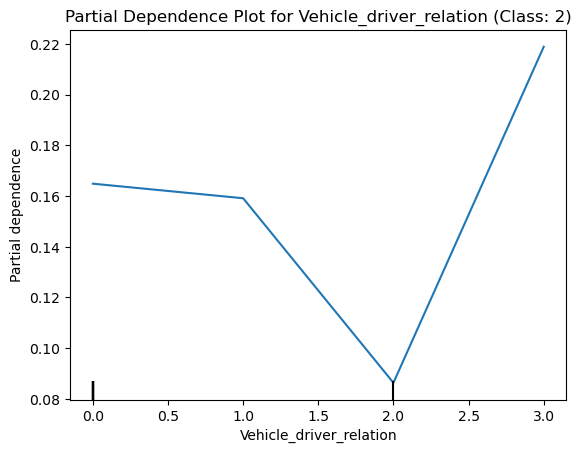

<Figure size 200x100 with 0 Axes>

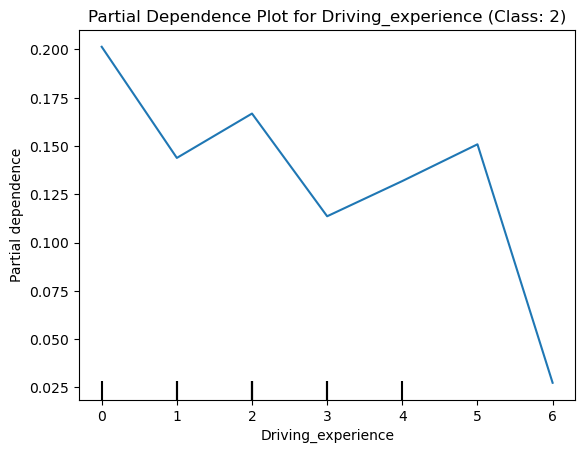

<Figure size 200x100 with 0 Axes>

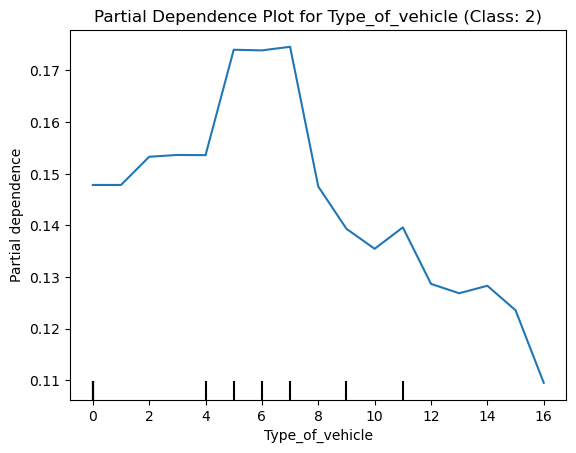

<Figure size 200x100 with 0 Axes>

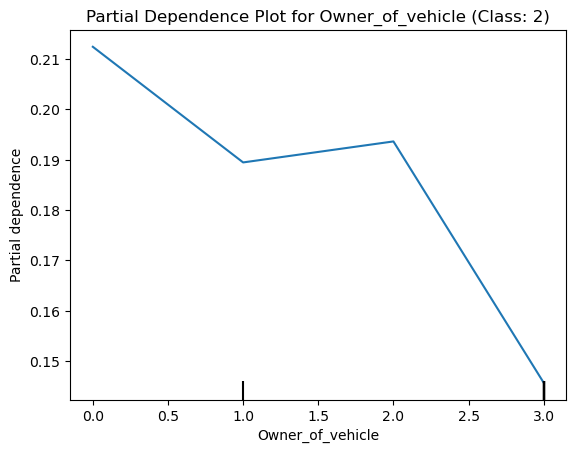

<Figure size 200x100 with 0 Axes>

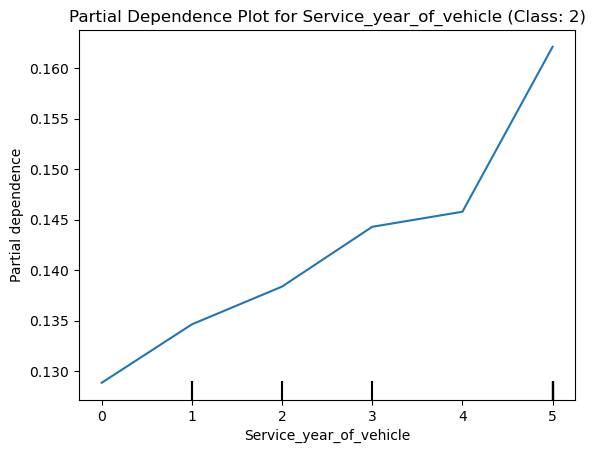

<Figure size 200x100 with 0 Axes>

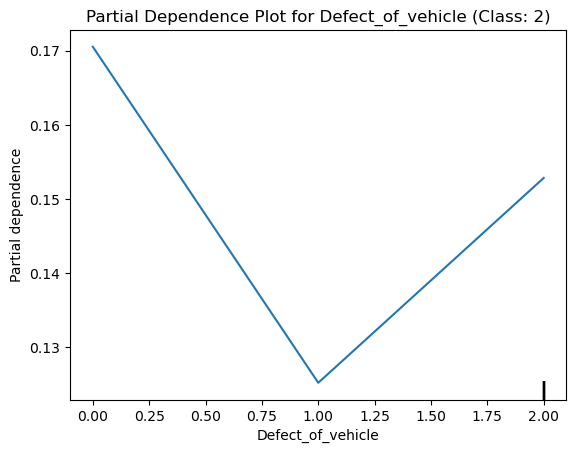

<Figure size 200x100 with 0 Axes>

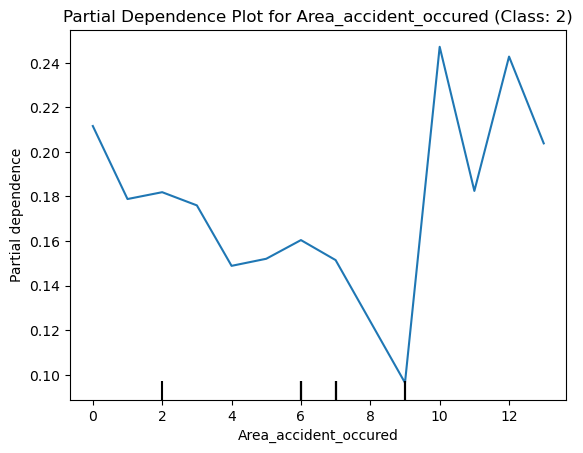

<Figure size 200x100 with 0 Axes>

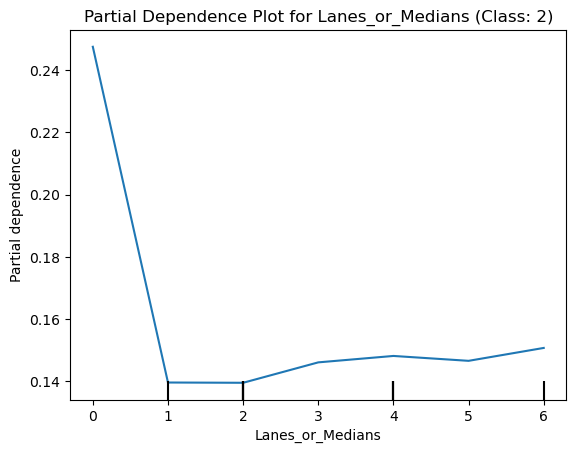

<Figure size 200x100 with 0 Axes>

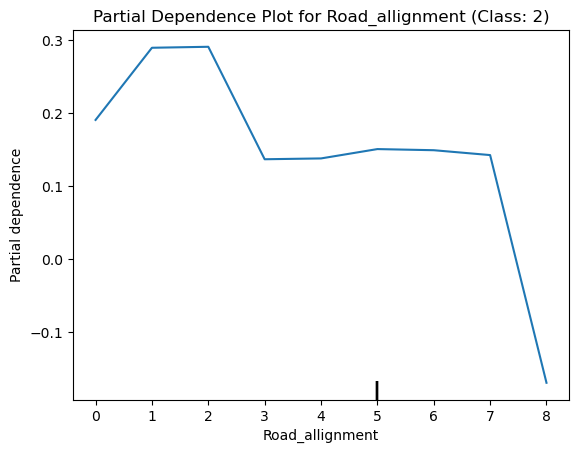

<Figure size 200x100 with 0 Axes>

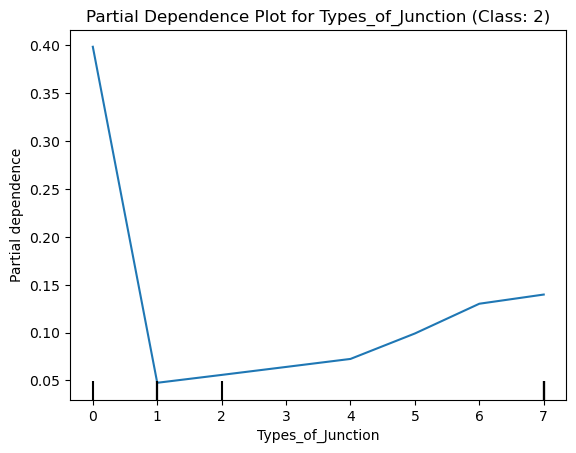

<Figure size 200x100 with 0 Axes>

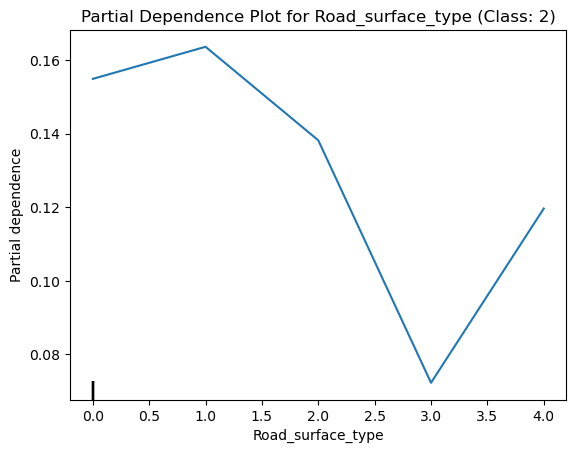

<Figure size 200x100 with 0 Axes>

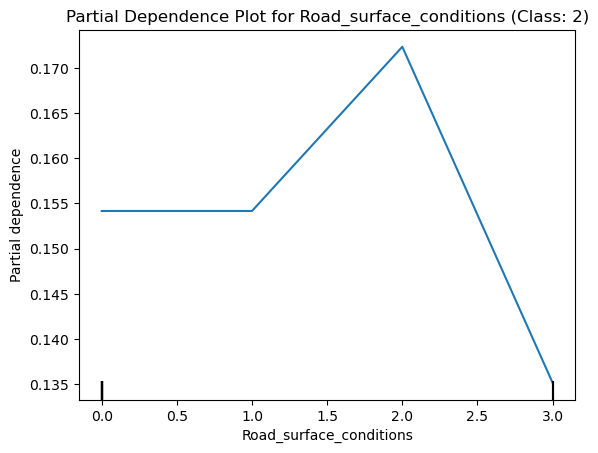

<Figure size 200x100 with 0 Axes>

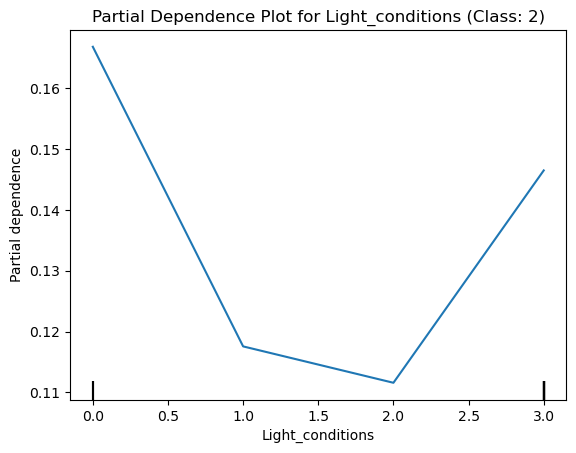

<Figure size 200x100 with 0 Axes>

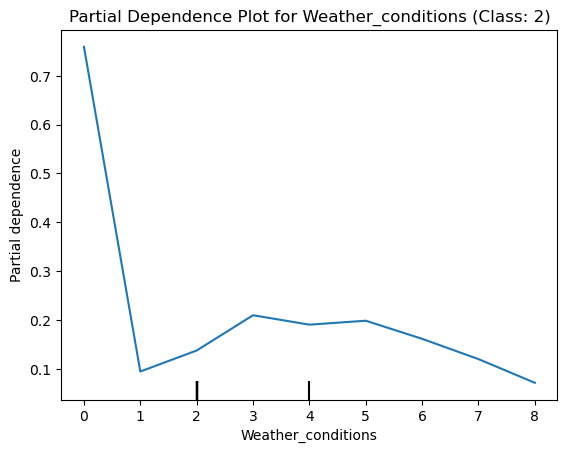

<Figure size 200x100 with 0 Axes>

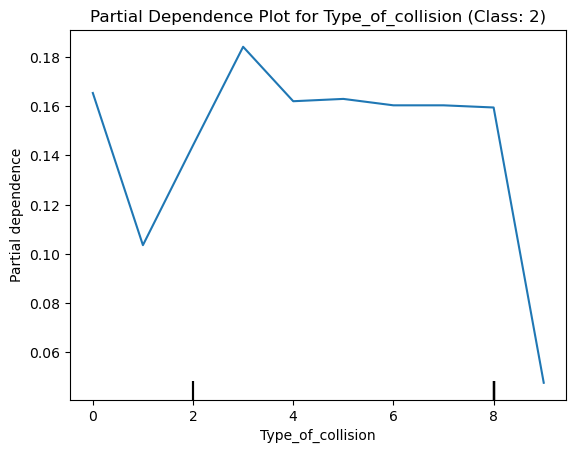

<Figure size 200x100 with 0 Axes>

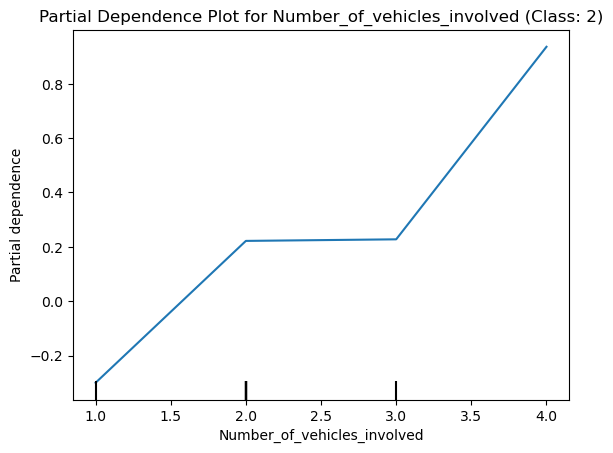

<Figure size 200x100 with 0 Axes>

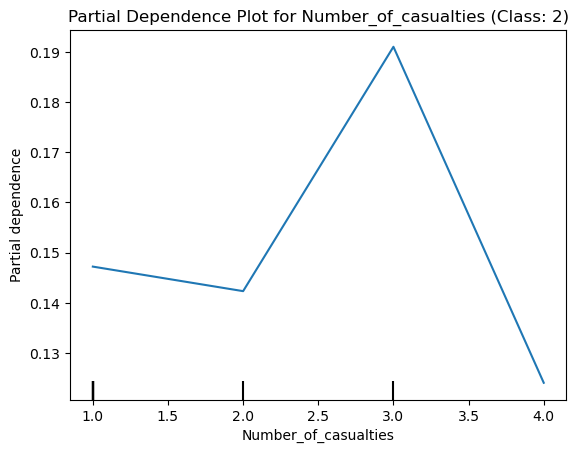

<Figure size 200x100 with 0 Axes>

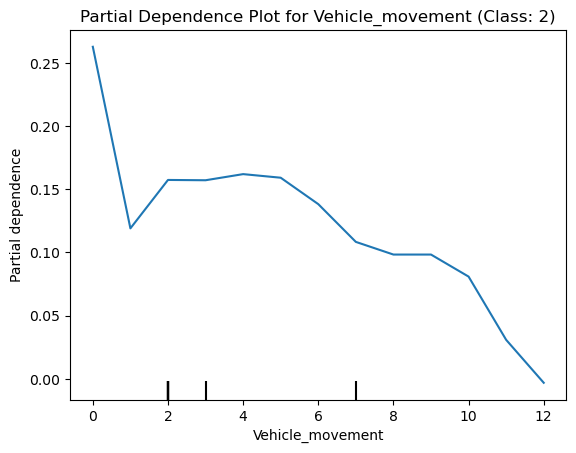

<Figure size 200x100 with 0 Axes>

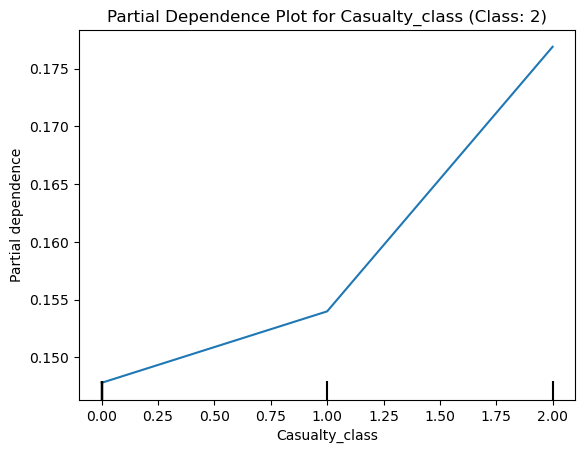

<Figure size 200x100 with 0 Axes>

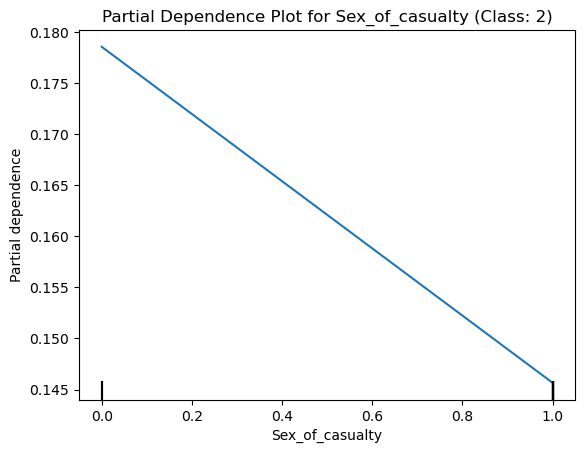

<Figure size 200x100 with 0 Axes>

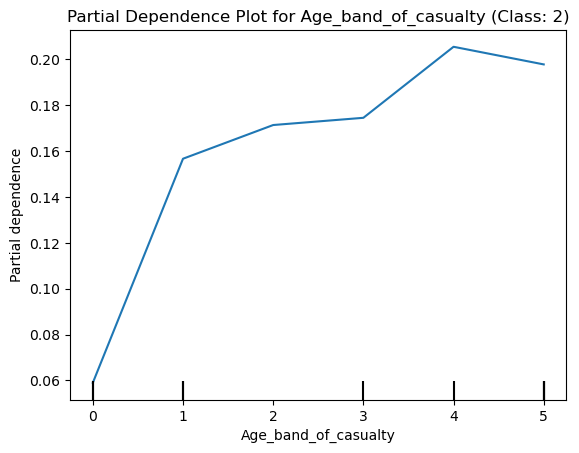

<Figure size 200x100 with 0 Axes>

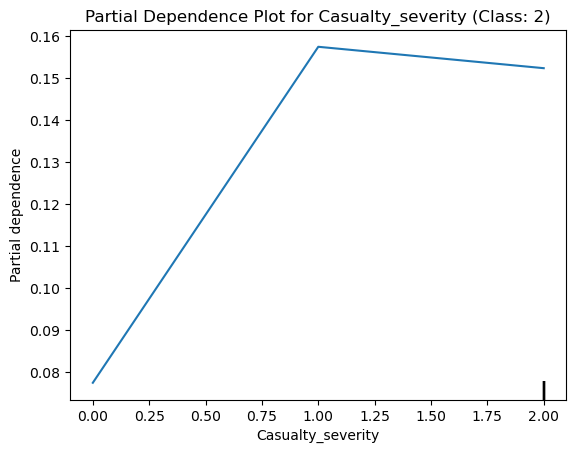

<Figure size 200x100 with 0 Axes>

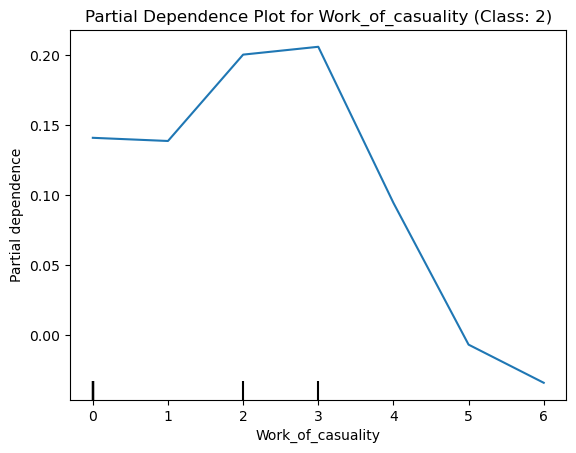

<Figure size 200x100 with 0 Axes>

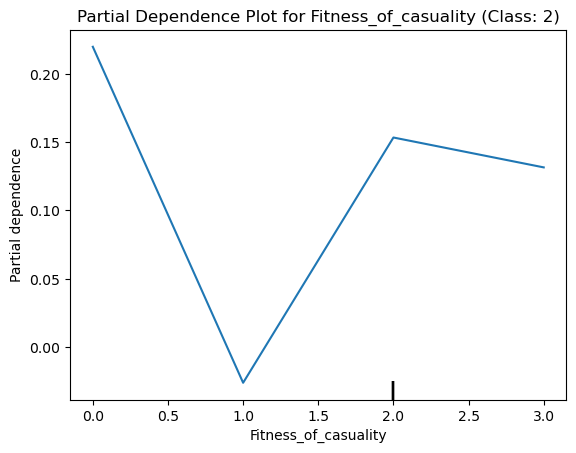

<Figure size 200x100 with 0 Axes>

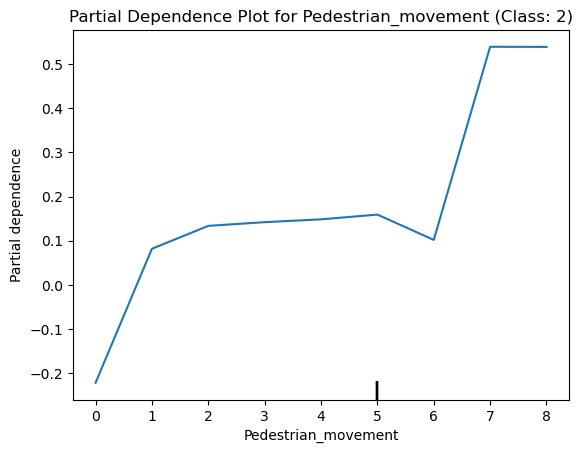

<Figure size 200x100 with 0 Axes>

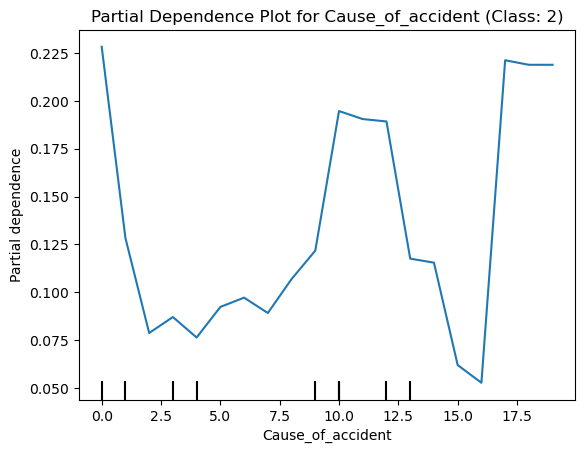

In [113]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# List all features you want to include in the PDP analysis
features_to_plot = X_test.columns.tolist()

# List of target classes you want to plot
target_classes = [0, 1, 2]  # Replace with the desired class indices

# Plot PDP for each feature and each target class
for target_class in target_classes:
    for feature in features_to_plot:
        plt.figure(figsize=(2, 1))  
        PartialDependenceDisplay.from_estimator(best_gb, X_test, [feature], target=target_class)
        plt.title(f'Partial Dependence Plot for {feature} (Class: {target_class})')
        plt.show()

In [114]:
print(model_predict(X_test).shape)  # Expected: (3583, num_classes)

(3583, 3)


In [115]:
shap_values = np.array(explainer.shap_values(X_test, nsamples='auto'))
print(f"Raw SHAP values shape: {shap_values.shape}")  # Expecting (3, 3583, 31)

  0%|          | 0/3583 [00:00<?, ?it/s]

Raw SHAP values shape: (3583, 31, 3)


In [116]:
shap_values = shap_values.transpose(2, 0, 1)  # Move class dimension to the front
print(f"Fixed SHAP values shape: {shap_values.shape}")  # Expected: (3, 3583, 31)

Fixed SHAP values shape: (3, 3583, 31)


In [117]:
num_classes = len(shap_values)  # Ensure it matches SHAP output
print(f"Number of classes detected: {num_classes}")

Number of classes detected: 3


In [118]:
print(f"Looping over range(0, {num_classes})")
for i in range(num_classes):
    print(f"Class {i} SHAP values shape: {shap_values[i].shape}")

Looping over range(0, 3)
Class 0 SHAP values shape: (3583, 31)
Class 1 SHAP values shape: (3583, 31)
Class 2 SHAP values shape: (3583, 31)


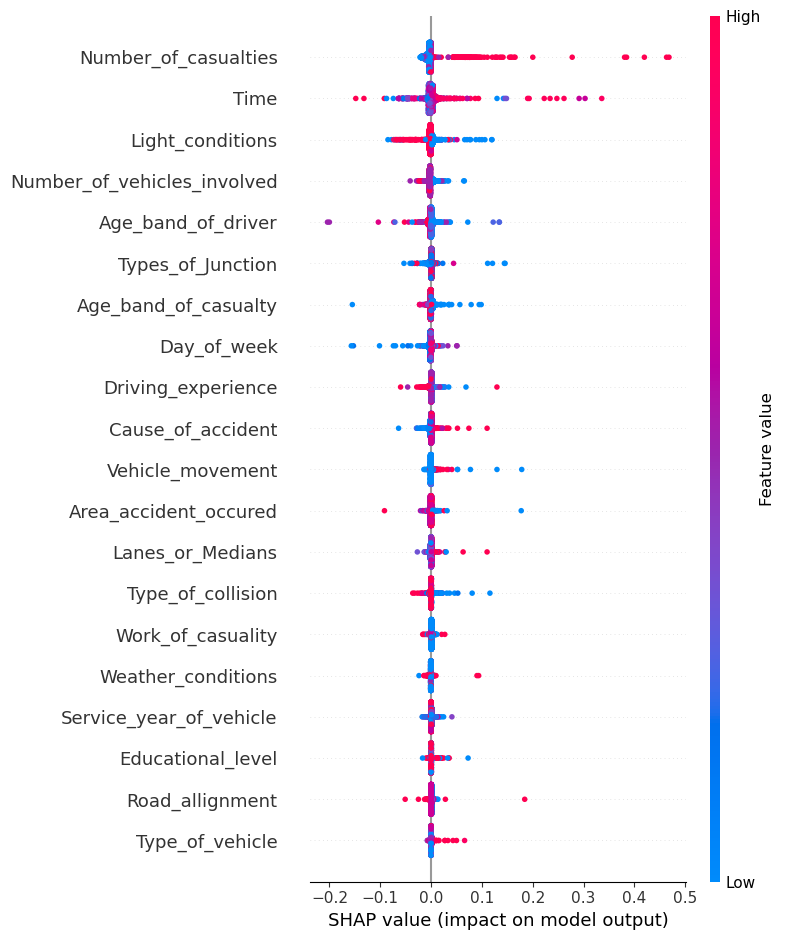

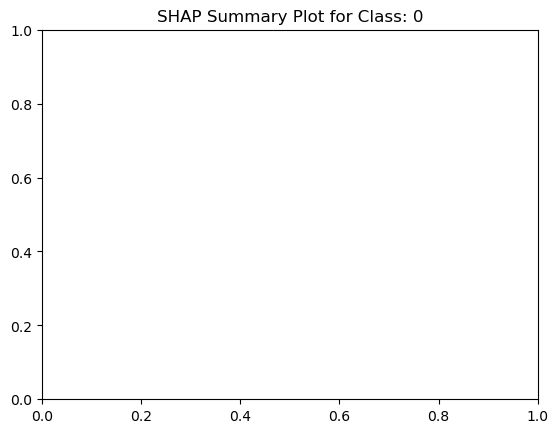

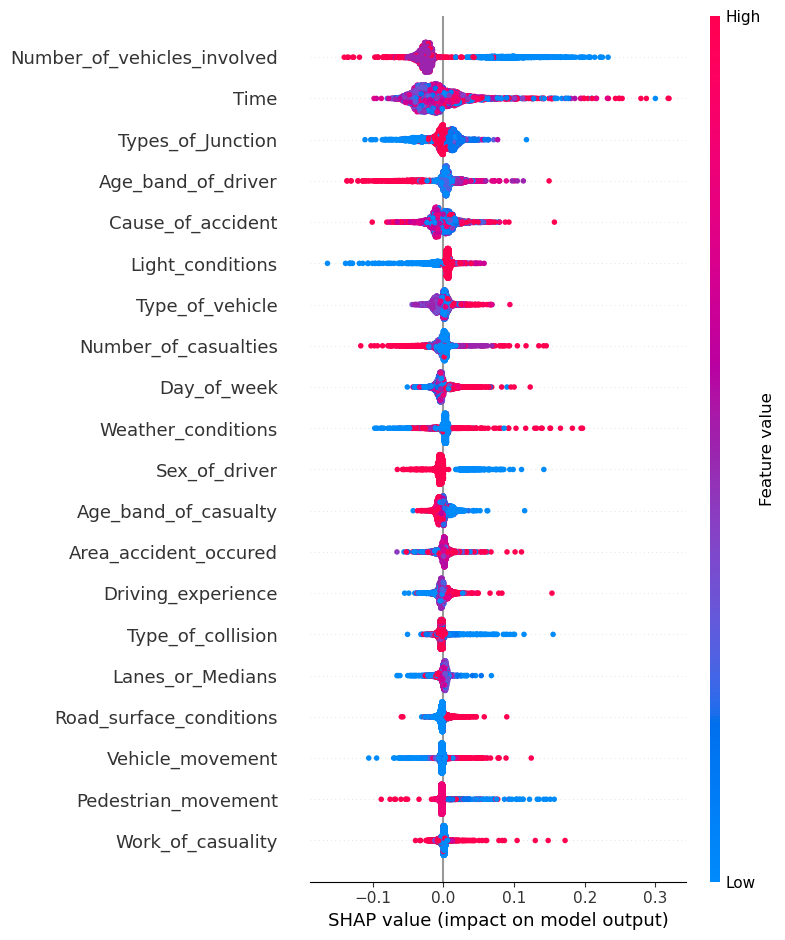

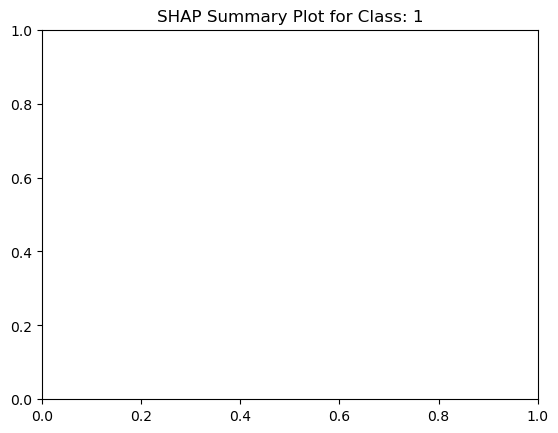

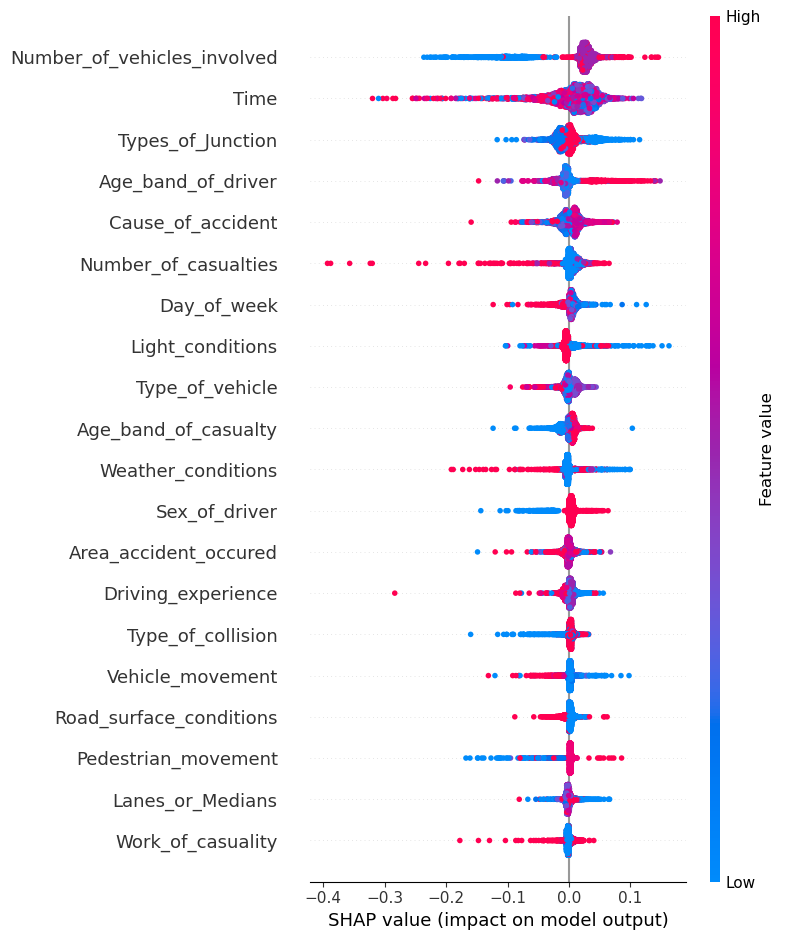

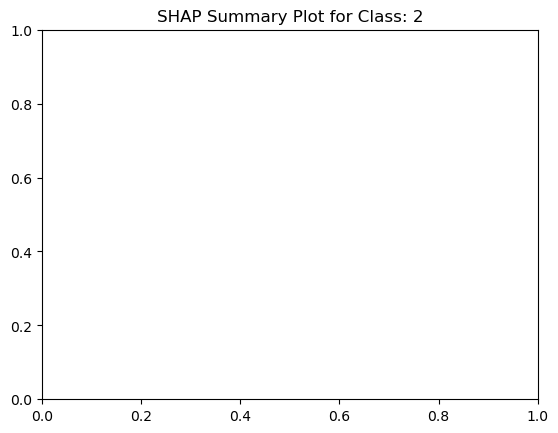

In [119]:
for class_index in range(num_classes):
    shap.summary_plot(shap_values[class_index], X_test.values, feature_names=X_test.columns)
    plt.title(f'SHAP Summary Plot for Class: {class_index}')
    plt.show()

In [120]:
# LIME (Local Interpretable Model-agnostic Explanations)
# drill down into specific instance predictions
import lime
import lime.lime_tabular

# Initialize LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=["Accident_severity"], discretize_continuous=True)

# Explain a specific instance from the test set
i = 10  # index of the instance
lime_exp = lime_explainer.explain_instance(X_test.values[i], best_model.predict_proba, num_features=10)

# Show the explanation
lime_exp.show_in_notebook()


#### **1. Prediction Probabilities**  
- The model predicts with **89% probability** (green bar) that the accident falls into a certain category (possibly "Not Severe").  
- The alternative class ("Other") has a **11% probability** (orange bar).  
- The "Accident_sev..." category has **0% probability**, meaning the model is very confident that this is not a severe accident.  

#### **2. Most Influential Features**  
The SHAP values indicate which features had the most impact on the model’s prediction. Some key insights:  
- **"Number_of_vehicles_involved" (SHAP value ≈ 0.04)**: More vehicles involved increased the likelihood of classification.  
- **"Sex_of_driver" (SHAP value ≈ 0.03)**: Gender had a slight impact.  
- **"Light_conditions" (SHAP value ≈ 0.03)**: Light conditions played a small role.  
- **"Time" (375 - 622 range, SHAP value ≈ 0.02)**: Time of the accident was relevant but not dominant.  
- **Other factors (e.g., road surface type, casualties, cause of accident, and road alignment)** had minor influences.  

#### **3. Feature Importance Table (Right Side)**  
- The **orange-colored** features **pushed the prediction upward** (i.e., towards the predicted class).  
- The **blue-colored** features **pushed the prediction downward** (i.e., against the predicted class).  
- For example, **"Number_of_vehicles_involved" = 2.00** is an important factor, suggesting accidents with **two vehicles** were more common in this prediction category.  

### **Conclusion**  
- The model is very **confident (89%)** in its prediction.  
- The **number of vehicles involved, light conditions, and time of the accident** were the most influential factors.  
- Other features like **road surface type and number of casualties** had minor effects.  
- The SHAP plot **explains why the model made this decision**, helping interpret the accident severity classification.  

